출처: https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering/notebook

# Introduction: Manual Feature Engineering

이 competition이 처음이라면 [이 노트북](https://www.kaggle.com/code/jundthird/start-here-a-gentle-introduction)을 체크하고 오는 것을 추천드립니다.

이 노트북에서는 Home Credit Default Risk competition을 위해 직접 feature을 만드는 방법을 살펴볼 것입니다. 이전 노트북에서는 모델을 구축하기 위해 ```application``` 데이터만 사용했습니다.  이 데이터로 만든 best model은 LB에서 약 0.74점을 받았습니다. 이 점수를 높이려면 다른 데이터 프레임에서 더 많은 정보를 포함해야 합니다. 여기에서는 ```Bureau``` 및 ```Bureau_balance``` 데이터의 정보를 사용하는 방법을 살펴보겠습니다. 

이 두개의 데이터 파일의 정의는 다음과 같습니다:

- bureau: Home Credit에 신고된 다른 금융 기관과의 고객의 이전 대출에 대한 정보. 각각의 이전 대출 정보는 자신의 행을 가지고 있습니다.
- bureau_balance: 이전 대출 정보에 관한 월별 정보입니다. 각각의 달은 자체 행을 가지고 있습니다.

직접하는 feature enginerring은 지루한 프로세스일 수 있으며(feature tool로 자동화된 feature engineering을 사용하는 이유) 종종 도메인 전문 지식에 의존합니다. 그리고 대출과 디폴트 가능성에 대한 지식이 부족하기 때문에 final training 데이터 프레임에서 가능한 한 많은 정보를 얻는 데 집중할 것입니다. 이 아이디어는 모델이 우리가 결정하지 않고 어떤 feature이 중요한지 대신 선택한다는 것입니다. 기본적으로, 여기서의 접근 방식은 가능한 한 많은 feature을 만든 다음, 모든 feature을 모델에 제공하여 사용하는 것입니다! 나중에 모델의 feature importances 또는 PCA와 같은 다른 테크닉을 사용하여 feature reduction를 수행할 수 있습니다.

직접하는 feature engineering 프로세스에는 많은 Pandas 코드와 많은 practice manipulation data가 포함됩니다. automated feature engineering 도구가 제공되기 시작했지만, feature engineering은 아직 더 많은 Data Wrangling(raw data를 보다 쉽게 접근하고 분석할 수 있도록 데이터를 정리하고 통합하는 과정)을 사용하여 완료해야 합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")

## Example: Counts of a client's previous loans

직접하는 feature engineering의 일반적인 프로세스를 설명하기 위해 먼저 다른 금융 기관에서 고객의 이전 대출 정보의 수를 간단히 가져옵니다. 

이를 위해서는 아래의 Pandas 작업이 많이 필요합니다:

- ```groupby```: 데이터 프레임을 칼럼으로 그룹화합니다. 이 경우 고유한 클라이언트를 나타내는 SK_ID_CURR 칼럼을 기준으로 그룹화합니다.
- ```agg```: 칼럼의 평균을 취하는 것과 같이 그룹화된 데이터에 대한 계산을 수행합니다. 함수를 직접 호출하거나(```grouped_df.mean()```) agg 함수를 리스트와 함께 사용할 수 있습니다(```grouped_df.agg([mean, max, min, sum])```)
- ```merge```: 계산된 통계를 적절한 클라이언트와 합칩니다. 클라이언트가 해당하는 통계를 가지고 있지 않은 모든 셀에 NaN을 삽입할 SK_ID_CURR 열의 계산된 통계와 original training data를 합쳐야 합니다.

이것은 많은 것처럼 보일 수 있습니다. 그래서 우리는 결국 이 과정을 대신할 함수를 만들 것입니다. 먼저 이를 직접 구현하는 방법을 살펴보겠습니다.

In [2]:
bureau = pd.read_csv('./home_credit/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [3]:
previous_loan_counts = bureau.groupby("SK_ID_CURR", as_index=False)["SK_ID_BUREAU"].count()\
                             .rename(columns={"SK_ID_BUREAU": "previous_loan_counts"})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [4]:
train = pd.read_csv("./home_credit/application_train.csv")
train = train.merge(previous_loan_counts, on="SK_ID_CURR", how="left")

train["previous_loan_counts"] = train["previous_loan_counts"].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Assessing Usefulness of New Variable with r value

새로운 변수가 유용한지 확인하기 위해 이 변수와 target 사이의 피어슨 상관 계수(r-value)를 계산할 수 있습니다. 이것은 두 변수 사이의 선형 관계 강도를 측정하며 범위는 -1(완전한 음의 선형관계)에서 +1(완전한 양의 선형관계)까지입니다. r-value는 새로운 변수의 유용성을 가장 잘 측정하는 것은 아니지만 변수가 machine learning model에 도움이 될지 안될지에 대한 첫 번째 추정을 제공할 수 있습니다. target에 대한 변수의 r-value가 클수록 이 변수의 변화가 target 값에 영향을 미칠 가능성이 커집니다. 따라서 우리는 target에 상대적인 절대값 r-value가 가장 큰 변수를 찾습니다.

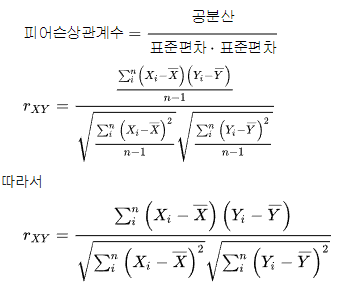

또한, KDE(Kernel Density Estimate) plot을 사용하여 target과의 관계를 시각적으로 체크할 수도 있습니다.

### Kernel Density Estimate Plots

The kernel density estimate plot은 하나의 변수의 분포를 보여줍니다 (스무스한 히스토그램으로 생각하면 됩니다). categorical 변수의 값에 따라 분포의 차이를 확인하기 위해 category에 따라 색깔을 다르게 지정할 수 있습니다. 예를 들어, ```TARGET``` = 1 or 0인지 여부에 따라 색상이 정해진 ```previous_loan_count```의 kernel density estimate를 표시할 수 있습니다. KDE는 대출을 상환하지 않은 사람(```TARGET == 1```)과 상환한 사람들(```TARGET == 0```) 사이의 분포가 상당히 다르다는 것을 보여줄 것입니다. 이는 변수가 machine learning model과의 관련 여부를 나타내는 지표로 사용될 수 있습니다.

이 plotting 기능을 모든 변수에 재사용할 수 있도록 함수에 넣을 것입니다.

In [5]:
def kde_target(var_name, df):
    
    corr = df["TARGET"].corr(df[var_name])
    
    avg_repaid = df.loc[df["TARGET"] == 0, var_name].median()
    avg_not_repaid = df.loc[df["TARGET"] == 1, var_name].median()
    
    plt.figure(figsize=(12, 6))
    
    sns.kdeplot(df.loc[df["TARGET"] == 0, var_name], label="TARGET == 0")
    sns.kdeplot(df.loc[df["TARGET"] == 1, var_name], label="TARGET == 1")
    
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend(loc="best")
    
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

Random Forest와 Gradient Boosting Machine에 [가장 중요한 변수 중 하나로 밝혀진](https://www.kaggle.com/code/jundthird/start-here-a-gentle-introduction) ```EXT_SOURCE_3```를 사용하여 이 feature을 테스트하겠습니다.

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


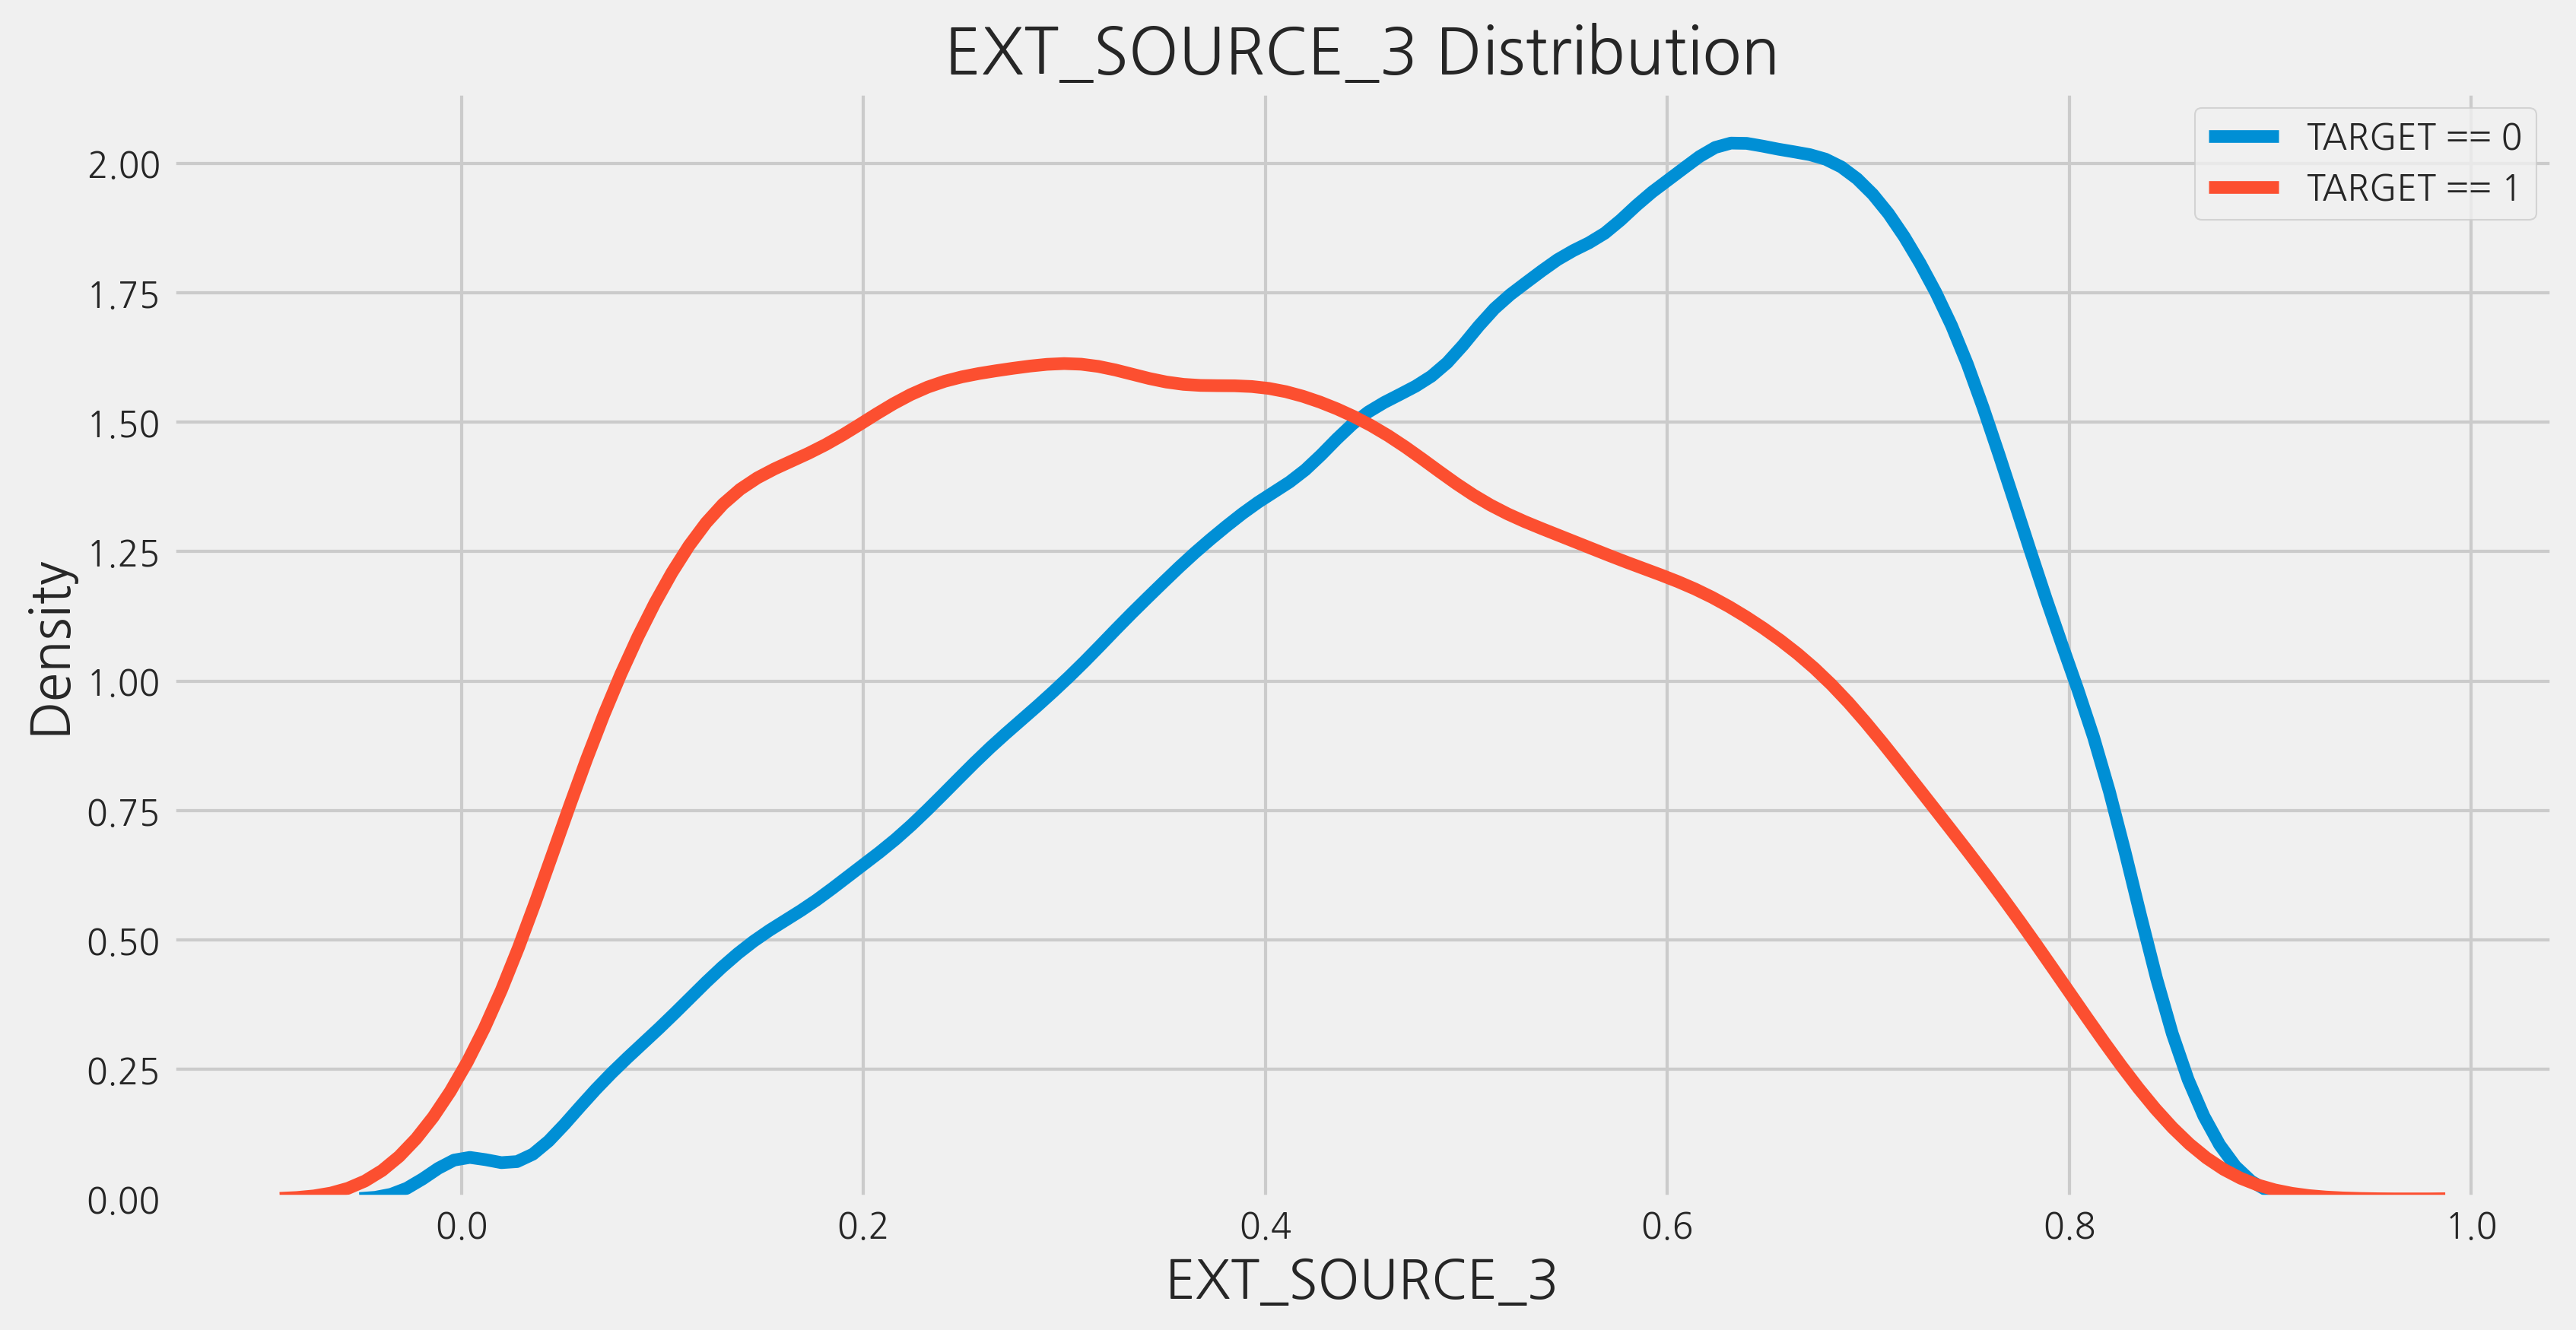

In [6]:
kde_target('EXT_SOURCE_3', train)

이제 방금 만들었던 새로운 feature인 previous_loan_counts를 확인해봅시다.

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


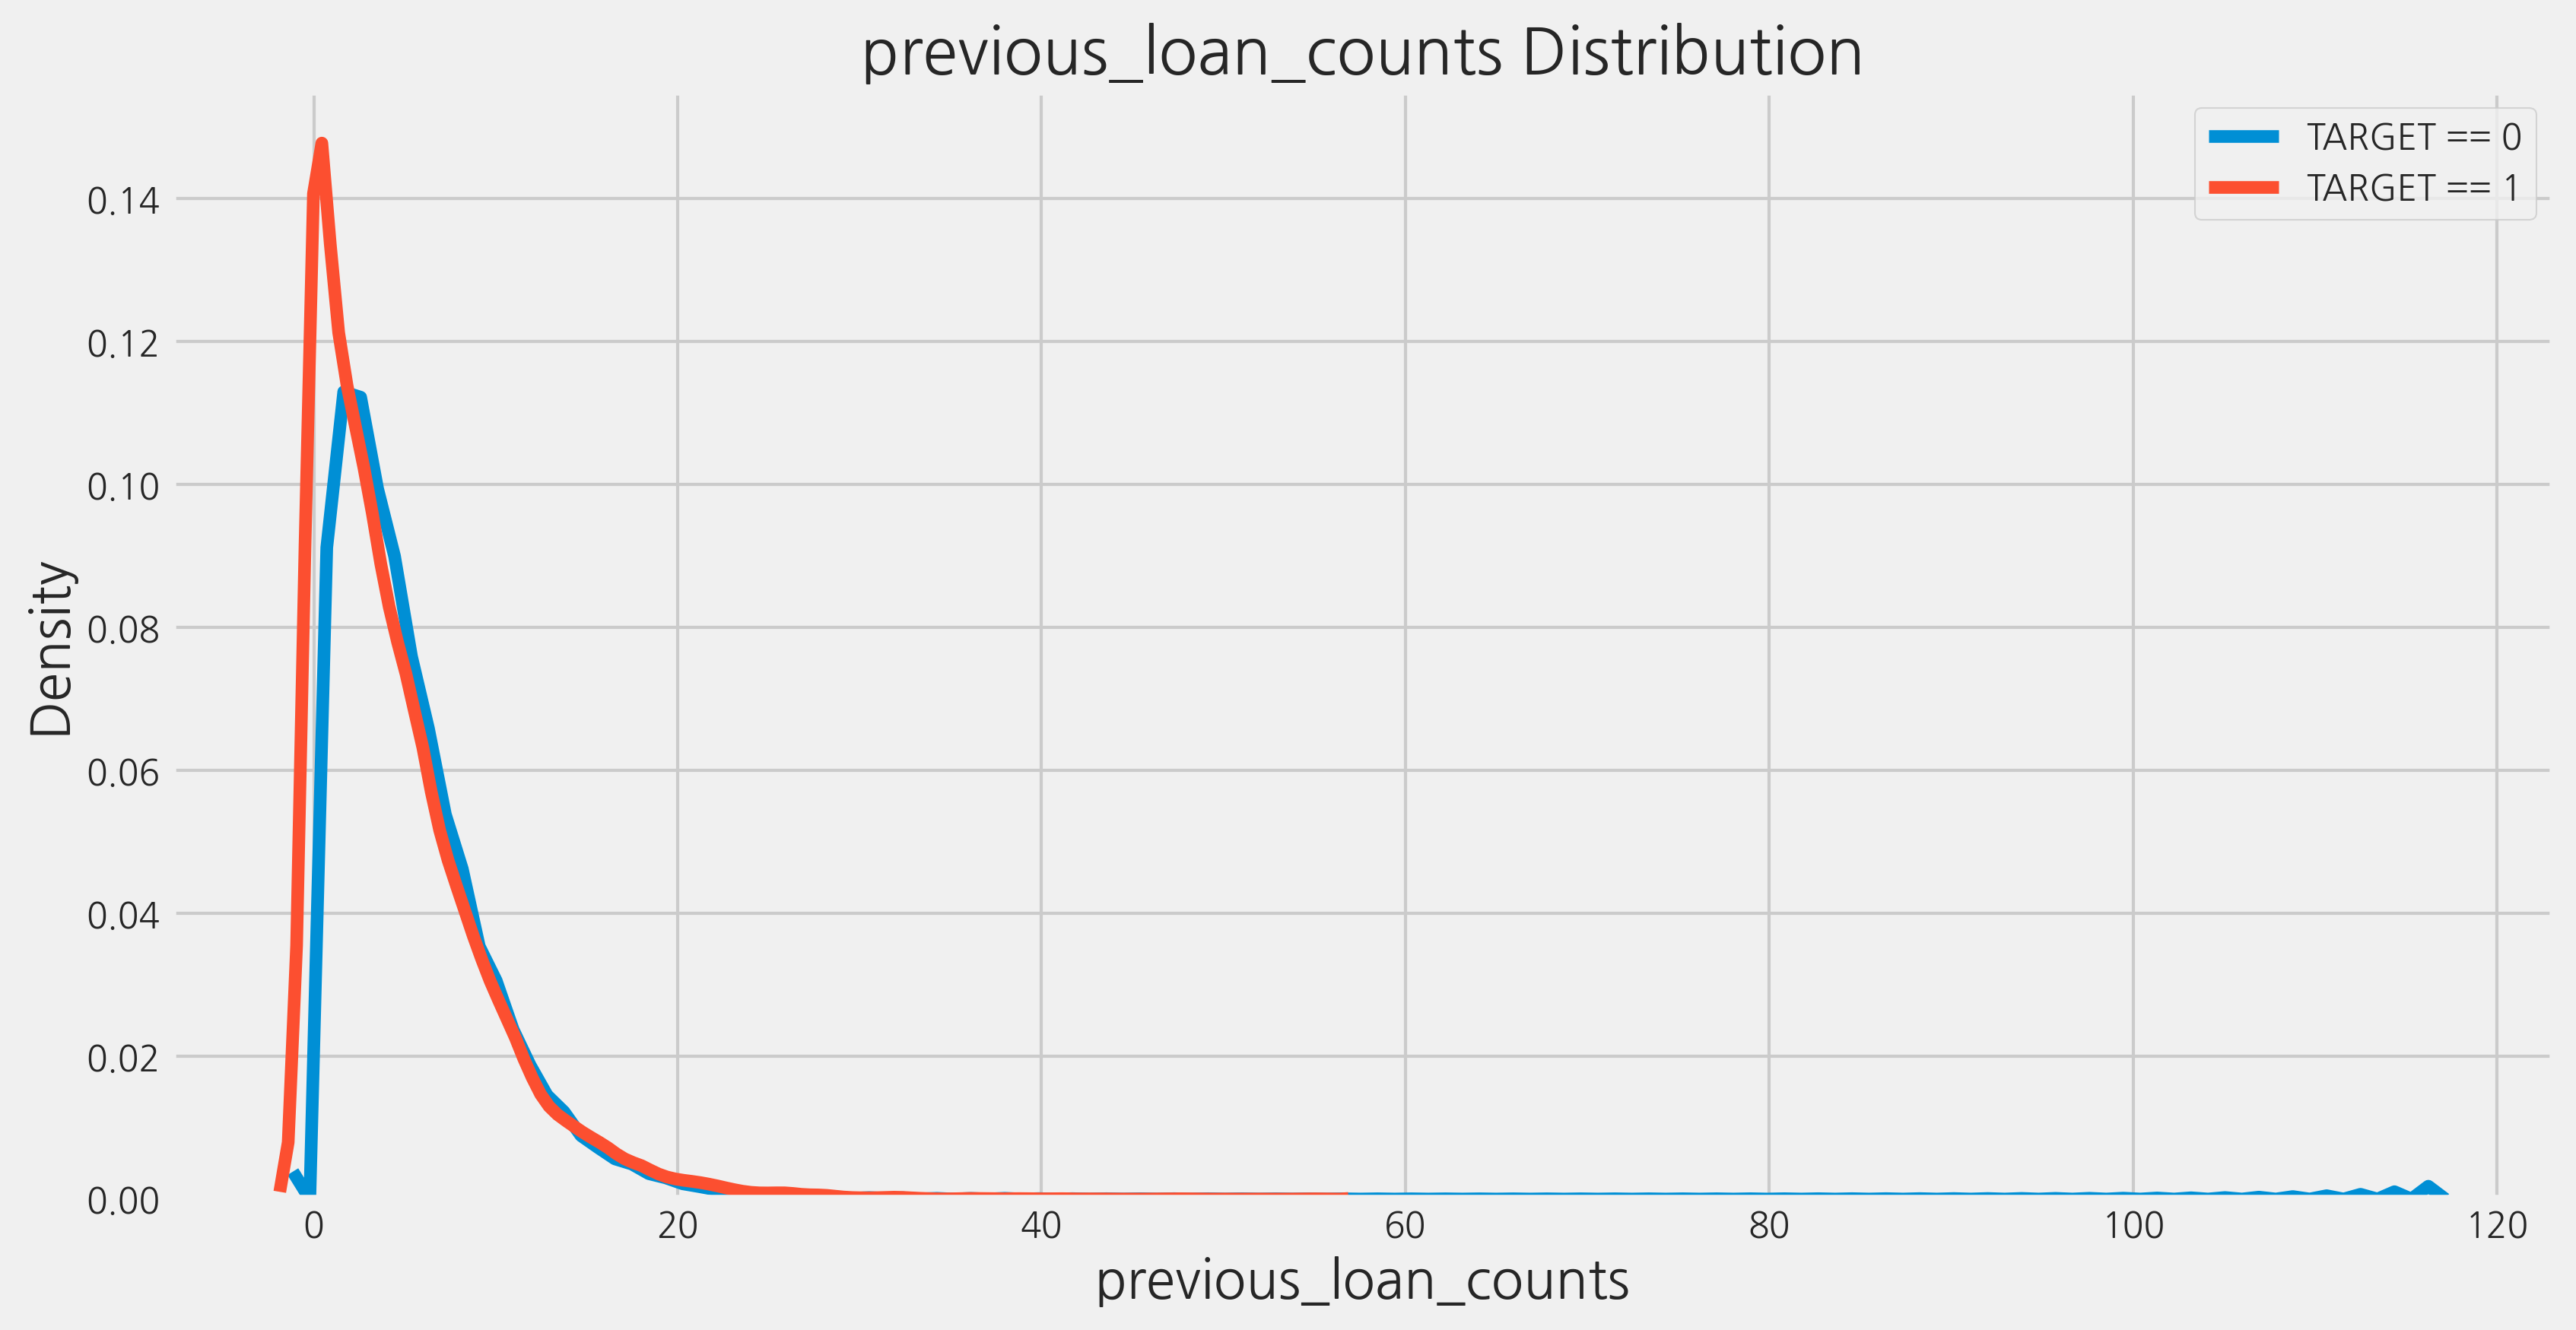

In [7]:
kde_target('previous_loan_counts', train)

이 변수가 중요한지 아닌지를 파악하기는 어렵습니다. 상관계수는 매우 약하며 분포에서는 눈에 띄는 차이가 없습니다.

계속해서 bureau 데이터 프레임에서 몇 가지 변수를 더 만들어 보겠습니다. 우리는 bureau 데이터 프레임에 있는 모든 numeric 칼럼의 평균, 최소값, 최대값을 가져올 것입니다.

## Aggregating Numeric Columns

```bureau``` 데이터 프레임의 숫자 정보를 설명하기 위해 모든 숫자 칼럼에 대한 통계를 계산할 수 있습니다. 이를 위해 고객 ID별로 그룹화하고 그룹화된 데이터 프레임을 ```agg```하고 결과를 다시 training data에 병합합니다. agg 함수는 작업이 유효한 것으로 간주되는 숫자 칼럼에 대한 값만 계산합니다. 여기서는 'mean', 'max', 'min', 'sum'을 계속 사용할 것이지만, 어떠한 다른 함수도 여기에 전달할 수 있습니다. 자체 함수를 작성하여 ```agg``` 호출에서 사용할 수도 있습니다.

In [8]:
bureau_agg = bureau.drop(columns=["SK_ID_BUREAU"]).groupby("SK_ID_CURR", as_index=False).\
                    agg(["count", "mean", "max", "min", "sum"]).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

이러한 각 칼럼에 대해 새 이름을 만들어야 합니다. 다음 코드는 이름에 stat을 추가하여 새 이름을 만듭니다. 여기서 우리는 데이터 프레임의 multi-level 인덱스를 다뤄야 합니다. multi-level index는 작업하기 어려우므로 single level 인덱스로 줄여줍니다.

In [9]:
columns = ["SK_ID_CURR"]
for var in bureau_agg.columns.levels[0]:
    if var != "SK_ID_CURR":
        
        # Index(['count', 'mean', 'max', 'min', 'sum', ''], dtype='object')
        # 위의 인덱스와 같기 때문에 마지막 칼럼은 포함해 주지 않는다.
        for stat in bureau_agg.columns.levels[1][:-1]:
            columns.append("bureau_%s_%s" % (var, stat))

In [10]:
# bureau_agg.columns
# MultiIndex([(            'SK_ID_CURR',      ''),
#             (           'DAYS_CREDIT', 'count'),
#             (           'DAYS_CREDIT',  'mean'),
#             (           'DAYS_CREDIT',   'max'),
#             (           'DAYS_CREDIT',   'min'),
#             (           'DAYS_CREDIT',   'sum'),
            
#                           .....
            
#             (           'AMT_ANNUITY', 'count'),
#             (           'AMT_ANNUITY',  'mean'),
#             (           'AMT_ANNUITY',   'max'),
#             (           'AMT_ANNUITY',   'min'),
#             (           'AMT_ANNUITY',   'sum')],
#            )

bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


training data와 ```merge```해줍니다.

In [11]:
train = train.merge(bureau_agg, on="SK_ID_CURR", how="left")
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


### Correlations of Aggregated Values with Target

모든 새로운 값과 target 값의 상관관계를 계산할 수 있습니다. 그리고 이것을 모델링에 중요할 수 있는 변수의 근사치로 사용할 수 있습니다.

In [12]:
new_corrs = []

for col in columns:
    corr = train["TARGET"].corr(train[col])
    new_corrs.append((col, corr))

아래 코드에서는 정렬된 Python 함수를 사용하여 크기(절대 값)로 상관 관계를 정렬합니다.

In [13]:
new_corrs = sorted(new_corrs, key=lambda x: abs(x[1]), reverse=True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.089728967219981),
 ('bureau_DAYS_CREDIT_min', 0.07524825103010374),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968684),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.055887379843920795),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.053734895601020585),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758622),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997309),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.048853502611115936),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483553),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04286392247073023),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484667),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.0414036353530601),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632898),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921615996),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.03049230665332547)]

새로운 변수들이 ```TARGET```과 유의미한 상관관계를 가지고 있지 않습니다.

상관관계가 가장 높은 ```bureau_DAYS_CREDIT_mean```를 KDE plot으로 확인해 봅니다.

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


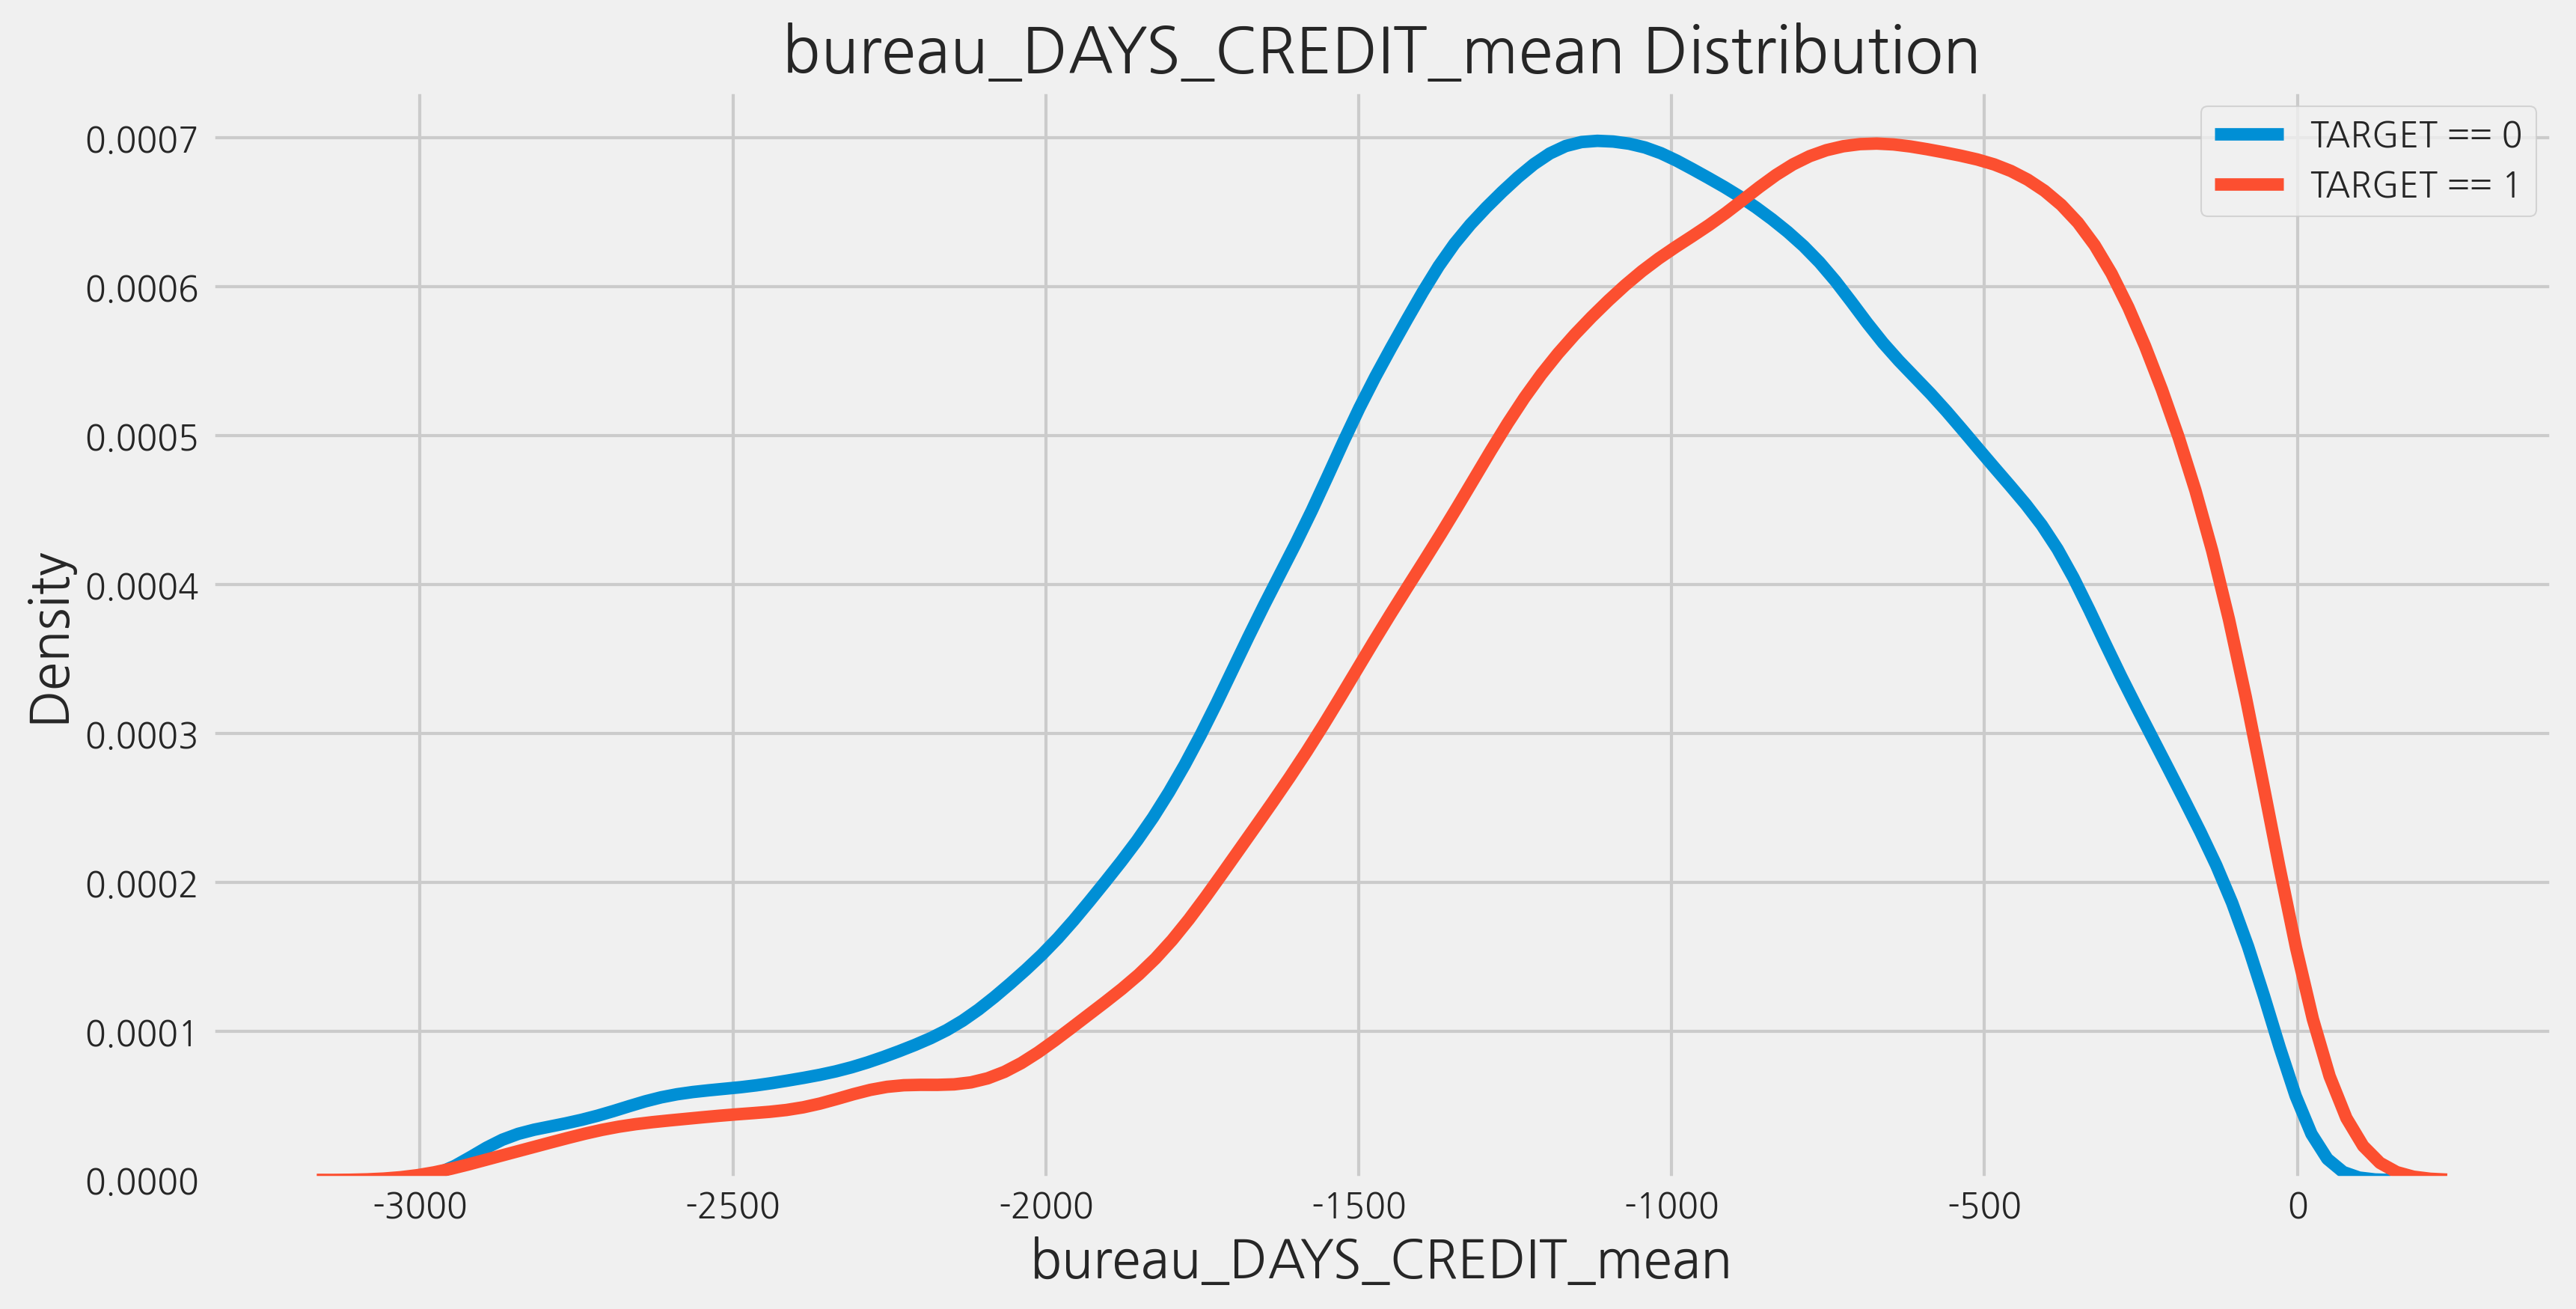

In [14]:
kde_target("bureau_DAYS_CREDIT_mean", train)

이 칼럼의 정의는 "고객이 현재 대출을 신청하기 며칠 전에 Credit Bureau credit을 신청했습니까?"입니다. 개인적인 해석은 Home Credit에서 대출을 신청하기 전에 예전의 대출이 신청된 일수입니다. 따라서 더 큰 음수는 대출이 현재의 대출 신청보다 더 예전에 있었음을 나타냅니다. 우리는 이 변수의 평균과 TARGET 사이에 매우 약한 양의 상관관계가 있음을 알 수 있습니다. 이는 과거에 더 많은 대출을 신청한 고객이 잠재적으로 Home Credit에서 대출을 상환할 가능성이 더 높다는 것을 의미합니다. 상관 관계가 약하기 때문에 signal만큼 노이즈가 발생할 가능성이 높습니다.

#### The Multiple Comparisons Problem

많은 변수가 있을 때 multiple comparisons로 알려진 문제인 단순한 우연에 의한 상관관계가 나타나기도 합니다. 우리는 수백 개의 feature을 만들 수 있으며 일부는 단순히 데이터의 random noise 때문에 TARGET과 상관 관계가 나타납니다. 이런 상황에서 모델이 학습을 하면, 이러한 변수들이 training set의 TARGET과 상관 관계가 있다고 여겨지기 때문에 overfitting이 일어나고, test set에 일반화하기가 힘들어집니다. 따라서, feature을 만들 때 많은 것들을 고려해야 합니다.

## Function for Numeric Aggregations

전에 numeric 칼럼에 했던 작업들을 함수로 캡슐화합니다.

In [15]:
def agg_numeric(df, group_var, df_name):
    # grouping 변수 외의 id 변수 제거
    for col in df:
        if col != group_var and "SK_ID" in col:
            df = df.drop(columns=col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes("number")
    
    # numeric_df[group_var] = group_ids
    
    agg = numeric_df.groupby(group_var).agg(["count", "mean", "max", "min", "sum"]).reset_index()
    
    columns = [group_var]
    
    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append("%s_%s_%s" % (df_name, var, stat))
                
    agg.columns = columns
    return agg

In [16]:
bureau_agg_new = agg_numeric(bureau.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


함수가 잘만들어졌는기 확인하기 위해 위에서 직접 만든 데이터프레임과 비교해 봅니다.

In [17]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


### Correlation Function

In [18]:
def target_corrs(df):
    corrs = []
    
    for col in df.columns:
        print(col)
        if col != "TARGET":
            corr = df["TARGET"].corr(df[col])
            corrs.append((col, corr))
            
    corrs = sorted(corrs, key=lambda x: abs(x[1]), reverse=True)
    return corrs

## Categorical Variables

카테고리형 변수에서는 각 value의 수를 계산합니다. 예를 들어, 다음과 같은 데이터 프레임이 있다면

| SK_ID_CURR | Loan type |
|------------|-----------|
| 1          | home      |
| 1          | home      |
| 1          | home      |
| 1          | credit    |
| 2          | credit    |
| 3          | credit    |
| 3          | cash      |
| 3          | cash      |
| 4          | credit    |
| 4          | home      |
| 4          | home      |

아래와 같이 만들어 줍니다.

| SK_ID_CURR | credit count | cash count | home count | total count |
|------------|--------------|------------|------------|-------------|
| 1          | 1            | 0          | 3          | 4           |
| 2          | 1            | 0          | 0          | 1           |
| 3          | 1            | 2          | 0          | 3           |
| 4          | 1            | 0          | 2          | 3           |

그런 다음 해당 값들에 대한 해당 카테고리형 변수의 총 개수로 값을 정규화할 수 있습니다(즉, 정규화된 개수는 각 관찰된 값에 대해 합이 1.0)

| SK_ID_CURR | credit count | cash count | home count | total count | credit count norm | cash count norm | home count norm |
|------------|--------------|------------|------------|-------------|-------------------|-----------------|-----------------|
| 1          | 1            | 0          | 3          | 4           | 0.25              | 0               | 0.75            |
| 2          | 1            | 0          | 0          | 1           | 1.00              | 0               | 0               |
| 3          | 1            | 2          | 0          | 3           | 0.33              | 0.66            | 0               |
| 4          | 1            | 0          | 2          | 3           | 0.33              | 0               | 0.66

위의 과정을 위해 첫번째로 one-hot encoding을 합니다.

In [19]:
categorical = pd.get_dummies(bureau.select_dtypes("object"))
categorical["SK_ID_CURR"] = bureau["SK_ID_CURR"]
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [20]:
categorical_grouped = categorical.groupby("SK_ID_CURR").agg(["sum", "mean"])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

```sum``` 칼럼은 관련있는 고객에 대한 해당 카테고리의 개수를 나타내고 ```mean```은 normalized count를 나타냅니다. one-hot encoding을 사용하면 이러한 수치를 매우 쉽게 계산할 수 있습니다

이제 ```CREDIT_ACTIVE_Active_count```, ```CREDIT_ACTIVE_Active_mean```과 같은 새로운 칼럼을 만듭니다.

In [21]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [22]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [23]:
group_var = "SK_ID_CURR"

columns = []

for var in categorical_grouped.columns.levels[0]:
    if var != group_var:
        for stat in ["count", "count_norm"]:
            columns.append("%s_%s" % (var, stat))
            
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


sum 칼럼은 count를 mean 칼럼은 normalized count를 나타냅니다.

이제 이 데이터프레임을 training data와 합칩니다.

In [24]:
train = train.merge(categorical_grouped, left_on="SK_ID_CURR", 
                    right_index=True, # 인덱스를 기준열로 사용
                    how="left")
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
train.shape

(307511, 229)

In [26]:
train.iloc[:10, 123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,-1149.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,-757.333333,-78.0,-1097.0,-2272.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,18.0,-1271.500000,-239.0,-2882.0,-22887.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,-1939.500000,-1138.0,-2741.0,-3879.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,-1773.000000,-1309.0,-2508.0,-7092.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Function to Handle Categorical Variables

이제 위의 코드들을 함수로 만들어 줍니다.

In [27]:
def count_categorical(df, group_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes("object"))
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(["sum", "mean"])
    
    column_names = []
    
    for var in categorical.columns.levels[0]:
        for stat in ["count", "count_norm"]:
            column_names.append("%s_%s_%s" % (df_name, var, stat))
            
    categorical.columns = column_names
    
    return categorical

In [28]:
bureau_counts = count_categorical(bureau, group_var='SK_ID_CURR', df_name='bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Applying Operations to another dataframe

이제 bureau balance 데이터 프레임으로 넘어갈 것입니다. 이 데이터 프레임에는 각 고객이 다른 금융 기관에 대한 예전 대출 내역에 대한 월별 정보가 있습니다. 이 데이터 프레임을 클라이언트 ID인 ```SK_ID_CURR```로 그룹화하는 대신 먼저 예전 대출의 ID인 ```SK_ID_BUREAU```로 데이터 프레임을 그룹화합니다. 이렇게 하면 각 대출에 대해 데이터 프레임의 한 행이 제공됩니다. 그런 다음 ```SK_ID_CURR```별로 그룹화하고 각 클라이언트의 대출에 대한 값을 계산할 수 있습니다. 최종 결과는 각 클라이언트에 대해 하나의 행이 있는 데이터 프레임이 될 것이며 대출에 대한 통계가 계산됩니다.

In [29]:
bureau_balance = pd.read_csv("./home_credit/bureau_balance.csv")
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


각 대출에 대한 각 상태의 value counts를 계산합니다.

In [30]:
bureau_balance_counts = count_categorical(bureau_balance, group_var="SK_ID_BUREAU",
                                          df_name="bureau_balance")
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


이제 하나의 숫자 칼럼을 처리할 수 있습니다. ```MONTHS_BALANCE``` 칼럼에는 신청 일수를 기준으로 한 몇 달 동안의 잔액이 있습니다. 이것은 numeric 변수만큼 중요하지 않을 수도 있으며 향후 작업에서 이것을 time 변수로 고려하고 싶을 수도 있습니다. 지금은 이전과 동일한 통계를 계산합니다.

In [31]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var="SK_ID_BUREAU",
                                 df_name="bureau_balance")
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


위의 데이터 프레임에는 각 대출에 대한 계산이 있습니다. 이제 각 클라이언트에 대해 이를 계산해야 합니다. 먼저 데이터 프레임을 병합하여 이를 수행한 다음 모든 변수가  numeric이므로 이번에는 SK_ID_CURR로 그룹화하여 통계를 다시 계산하기만 하면 됩니다.

In [32]:
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts,
                                          right_index=True,
                                          left_on="SK_ID_BUREAU",
                                          how="outer")

bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [33]:
bureau_by_loan = bureau_by_loan.merge(bureau[["SK_ID_BUREAU", "SK_ID_CURR"]],
                                      on="SK_ID_BUREAU",
                                      how="left")

bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [34]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns=["SK_ID_BUREAU"]),
                                       group_var="SK_ID_CURR", df_name="client")
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


짧게 요약하면 ```bureau_balance``` 데이터프레임에서:

1. 각 대출로 그룹핑하여 numeric stats를 계산하고
2. 대출로 그룹핑한 각각의 카테고리형 변수들의 value counts를 만들었으며
3. 대출에 대한 stats과 value counts를 합쳤고
4. clinet id로 그룹핑하여 위에서 만들어진 데이터 프레임에 대한 numercie stats을 계산했습니다.

최종 데이터 프레임에는 월별 잔액 정보와 함께 모든 대출에 대해 계산된 통계와 각 클라이언트에 대한 하나의 행이 있습니다.

몇몇 변수들은 무엇을 의미하는지 모호하기 때문에 조금 설명하자면:
- ```client_bureau_balance_MONTHS_BALANCE_mean_mean```: 각 대출에 대한 ```MONTHS_BALANCE```의 평균 값을 계산합니다. 그런 다음 각 고객에 대해 모든 대출에 대한 값들의 평균을 계산합니다.
- ```client_bureau_balance_STATUS_X_count_norm_sum```: 각 대출에 대해 ```STATUS``` == X의 수를 대출에 대한 총 ```STATUS``` 값으로 나눈 값을 계산합니다. 그런 다음 각 고객에 대해 각 대출에 대한 값을 더합니다.

<br/>

하나의 데이터 프레임에 모든 변수가 함께 포함될 때까지 상관 관계 계산을 보류합니다.

# Putting the Functions Together

이제 다른 기관에서의 예전 대출 정보와 이러한 대출에 대한 월별 지불 정보를 가져와 기본 training 데이터 프레임에 넣을 수 있는 모든 부분이 준비되었습니다. 모든 변수를 재설정한 다음 처음부터 이를 수행하기 위해 구축한 함수를 사용하겠습니다.

In [35]:
# 오래된 오브젝트를 제거함으로써 메모리 확보
import gc
gc.enable() # 자동으로 garbage 수거
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect() # 프로세스 추적

9064

In [36]:
# 새로 데이터 프레임 읽어오기
train = pd.read_csv('./home_credit/application_train.csv')
bureau = pd.read_csv('./home_credit/bureau.csv')
bureau_balance = pd.read_csv('./home_credit/bureau_balance.csv')

### Counts of Bureau Dataframe

In [37]:
bureau_counts = count_categorical(bureau, group_var="SK_ID_CURR", 
                                  df_name="bureau")
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Aggregated Stats of Bureau Dataframe

In [38]:
bureau_agg = agg_numeric(bureau.drop(columns=["SK_ID_BUREAU"]),
                         group_var="SK_ID_CURR",
                         df_name="bureau")
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


### Value counts of Bureau Balance dataframe by loan

In [39]:
bureau_balance_counts = count_categorical(bureau_balance, group_var="SK_ID_BUREAU",
                                          df_name="bureau_balance")
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


### Aggregated stats of Bureau Balance dataframe by loan

In [40]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var="SK_ID_BUREAU",
                                 df_name="bureau_balance")
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


### Aggregated Stats of Bureau Balance by Client

In [41]:
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index=True,
                                           left_on="SK_ID_BUREAU", how="outer")

bureau_by_loan = bureau[["SK_ID_BUREAU", "SK_ID_CURR"]].merge(bureau_by_loan,
                                                              on="SK_ID_BUREAU",
                                                              how="left")

bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns=["SK_ID_BUREAU"]),
                                       group_var="SK_ID_CURR",
                                       df_name="client")

## Insert Computed Features into Training Data

In [42]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [43]:
train = train.merge(bureau_counts, on="SK_ID_CURR", how="left")
train = train.merge(bureau_agg, on="SK_ID_CURR", how="left")
train = train.merge(bureau_balance_by_client, on="SK_ID_CURR", how="left")

In [44]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


# Feature Engineering Outcomes

모든 작업이 끝나면 이제 우리가 만든 변수를 살펴보겠습니다. 결측값 비율, TARGET과 변수의 상관관계, 다른 변수와 변수의 상관관계를 볼 수 있습니다. 변수 간의 상관 관계는 두 변수의 상관 관계가 높은 경우가 있는지 보여줍니다. 이러한 경우, 두 변수를 모두 갖는 것은 중복을 의미하기 때문에 종종 한 쌍의 colinear 변수에서 하나를 제거하려고 합니다. 또한, null 값의 비율을 사용하여 값의 대부분이 null 값인 feature을 제거할 수 있습니다. **feature selection**은 앞으로 중요한 사항이 될 것입니다. feature 수를 줄이면 모델 학습에 도움이 되고, 테스트 데이터에 더 generalize될 수 있기 때문입니다. "curse of dimensionality"는 너무 많은 feature(차원이 너무 높음)으로 인해 발생하는 문제를 의미합니다. 변수의 수가 증가함에 따라 이러한 변수와 TARGET 값 간의 관계를 학습하는 데 필요한 데이터 포인트의 수가 기하급수적으로 증가합니다.

Feature selection은 모델이 테스트 세트에 대해 더 잘 학습하고 일반화할 수 있도록 변수를 제거하는 프로세스입니다. 목적은 쓸모없는/중복 변수를 제거하면서 유용한 변수를 유지하는 것입니다. 이 프로세스에 사용할 수 있는 도구는 여러 가지가 있지만 이 노트북에서는 null 값 비율이 높은 칼럼과 서로 상관 관계가 높은 변수를 제거하는 방법을 시용합니다. 나중에 ```Gradient Boosting Machine``` 또는 ```Random Forest```와 같은 모델에서 feature importances를 사용하여 feature selection을 수행하는 방법을 살펴볼 수 있습니다.

## Missing Values

중요하게 고려해야 할 사항은 데이터 프레임의 null 값입니다. null 값이 너무 많은 칼럼은 삭제해야 할 수 있습니다.

In [45]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    mis_val_table_ren_columns = mis_val_table.rename(columns={0: "Missing Values",
                                                              1: "% of Total Values"})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0].\
                                                          sort_values("% of Total Values", ascending=False).round(1)
    
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
          "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
    
    return mis_val_table_ren_columns

In [46]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


null 값 비율이 높은 칼럼이 많이 있습니다. null 값을 제거하기 위한 잘 정립된 threshold는 없으며 최선의 방법는 문제에 따라 다릅니다. 여기에서는 feature 수를 줄이기 위해 training data나 testing data에서 null 값이 90%보다 큰 칼럼을 제거합니다.

In [47]:
missing_train_vars = list(missing_train.index[missing_train["% of Total Values"] > 90])
len(missing_train_vars)

0

null 값을 제거하기 전에 testing data에서 null 값의 백분율을 찾습니다. 그런 다음 training data 또는 testing data에서 null 값이 90%보다 큰 칼럼을 제거합니다. 이제 testing data를 읽고 동일한 작업을 수행하고 testing data에서 누락된 값을 살펴보겠습니다. 이미 모든 개수와 통계를 계산했으므로 testing data를 적절한 데이터와 병합하기만 하면 됩니다.

## Calculate Information for Testing Data

In [48]:
test = pd.read_csv("./home_credit/application_test.csv")

test = test.merge(bureau_counts, on="SK_ID_CURR", how="left")

test = test.merge(bureau_agg, on="SK_ID_CURR", how="left")

test = test.merge(bureau_balance_by_client, on="SK_ID_CURR", how="left")

In [49]:
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


train 데이터와 test 데이터의 칼럼을 맞추기 위해 ```align``` 함수를 사용합니다. 지금은 칼럼을 맞춰주지 않아도 문제가 되질 않지만, one-hot encoding을 한 경우, 각 데이터 프레임의 칼럼을 맞춰줘야 할 수 있습니다.

In [50]:
train_labels = train['TARGET']

train, test = train.align(test, join="inner", axis=1)

train["TARGET"] = train_labels

In [51]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


이제 데이터 프레임에 동일한 칼럼이 있습니다(training data의 ```TARGET``` 칼럼 제외). 이는 training dataset과 testing dataset 모두에서 동일한 칼럼을 가져야 하는 machine learning model에서 사용할 수 있음을 의미합니다.

이제 삭제해야 하는 칼럼을 파악할 수 있도록 testing data에서 null 값의 백분율을 살펴보겠습니다.

In [52]:
missing_test = missing_values_table(test)
missing_test.head()

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4


In [53]:
missing_test_vars = list(missing_test.index[missing_test["% of Total Values"] > 90])
len(missing_test_vars)

0

In [54]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [55]:
train = train.drop(columns=missing_columns)
test = test.drop(columns=missing_columns)

null 값이 90% 이상인 칼럼이 없기 때문에 여기에서는 칼럼을 제거하지 않았습니다. 차원을 줄이기 위해 다른 feature selection 방법을 적용해야 할 수도 있습니다.

이 시점에서 training data와 testing data를 모두 저장합니다. missing_columns을 삭제하기 위해 다른 비율을 적용해 결과를 비교하는 것을 추천합니다.

In [56]:
train.to_csv('train_bureau_raw.csv', index=False)
test.to_csv('test_bureau_raw.csv', index=False)

## Correlations
먼저 TARGET과 변수간의 상관관계를 살펴보겠습니다. 여기서 생성한 모든 변수가 training data(from ```application```)에 이미 존재하는 것보다 더 큰 상관관계를 가지고 있음을 알 수 있습니다.

In [57]:
corrs = train.corr()

In [58]:
corrs = corrs.sort_values("TARGET", ascending=False)

pd.DataFrame(corrs["TARGET"].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [59]:
pd.DataFrame(corrs["TARGET"].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


TARGET과 상관관계가 가장 높은 변수(본인 제외)는 새로 만든 변수입니다. 그러나 변수가 상관 관계가 있다고 해서 그것이 유용하다는 의미는 아니며 수백 개의 새로운 변수를 생성하면 일부는 단순히 random noise 때문에 TARGET과 상관 관계가 생길 수 있음을 기억해야 합니다.

조심스러운 관점에서 본다면, 새로 생성된 변수 중 몇 가지는 유용할 수 있습니다. 변수의 유용성을 평가하기 위해 모델에서 return하는 feature importances를 살펴보겠습니다. 호기심을 위해(그리고 이미 함수를 작성했기 때문에) 새로 생성된 두 변수의 kde plot을 만들어봅니다.

The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.0774
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid =     0.3636


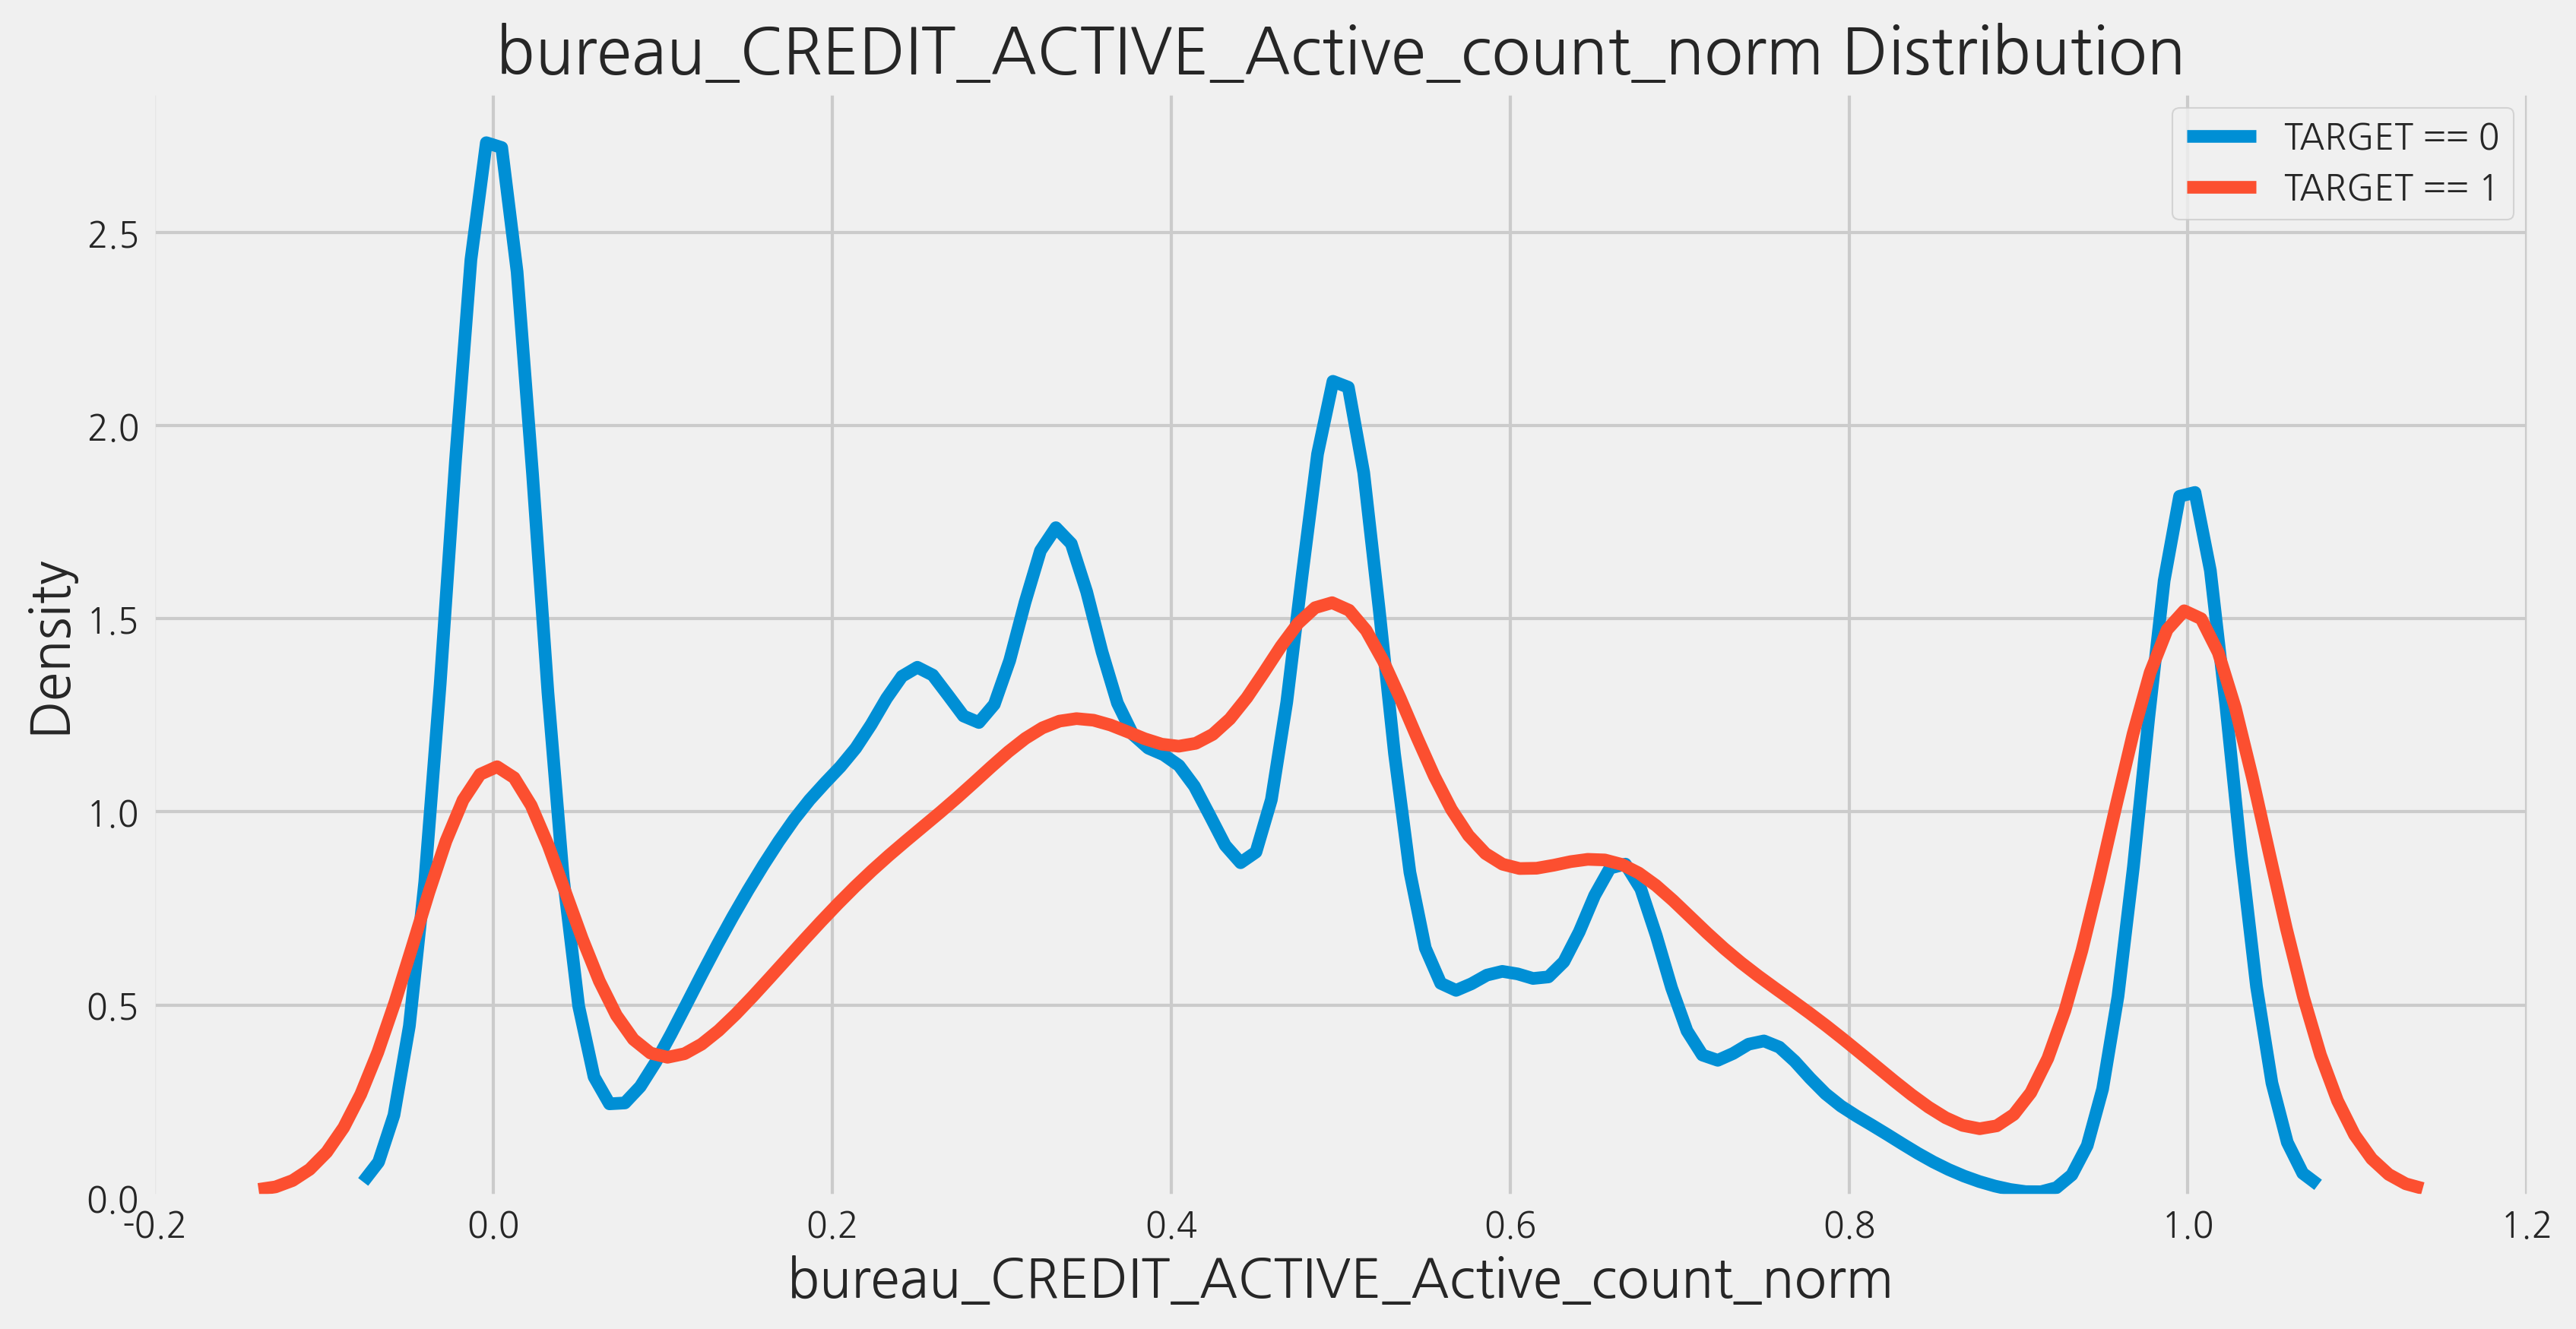

In [60]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

이 그래프를 보고 어떠한 결론을 내리긴 어려워 보입니다.

### Collinear Variables
TARGET과 변수의 상관관계뿐만 아니라 각 변수와 다른 모든 변수의 상관관계도 계산할 수 있습니다. 이렇게 하면 데이터에서 제거해야 하는 collinear 변수가 있는지 확인할 수 있습니다.

다른 변수와 상관관계가 0.8 이상인 변수를 찾아보겠습니다.

In [61]:
threshold = 0.8

above_threshold_vars = {}

for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

이러한 상관관계가 매우 높은 각각의 변수 pair에 대해서 하나만 제거하려고 합니다. 다음 코드는 각 pair 중 하나만 추가하여 제거할 변수 집합을 만듭니다.

In [62]:
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
                
                
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


training dataset과 testing dataset 모두에서 이러한 칼럼을 제거할 수 있습니다. 이러한 변수들을 제거한 후, performance를 이러한 변수들을 제거하기 전 dataset과 비교해야 합니다(이전에 저장한 raw csv 파일)

In [63]:
train_corrs_removed = train.drop(columns=cols_to_remove)
test_corrs_removed = test.drop(columns=cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 199)
Testing Corrs Removed Shape:  (48744, 198)


In [64]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index=False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index=False)

# Modeling

In [65]:
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [66]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    labels = features['TARGET']
    
    features = features.drop(columns=['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns=['SK_ID_CURR'])
    
    # one-hot encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        features, test_features = features.align(test_features, join='inner', axis=1)
        
        cat_indices = 'auto'
    
    # label encoding
    elif encoding == 'le':
        
        label_encoder = LabelEncoder()
        
        cat_indices = []
        
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                cat_indices.append(i)
    
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    feature_names = list(features.columns)
    
    features = np.array(features)
    test_features = np.array(test_features)
    
    k_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=50)
    
    feature_importance_values = np.zeros(len(feature_names))
    
    test_predictions = np.zeros(test_features.shape[0])
    
    # out of fold validation predictions == 각 fold에 대한 예측값을 앙상블하는 기법
    out_of_fold = np.zeros(features.shape[0])
    
    valid_scores = []
    train_scores = []
    
    for train_indices, valid_indices in k_fold.split(features, labels):
        
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        model = lgb.LGBMClassifier(n_estimators=10000, objective='binary', 
                                   class_weight='balanced', learning_rate=0.05, 
                                   reg_alpha=0.1, reg_lambda=0.1, 
                                   subsample=0.8, n_jobs=-1, random_state=50)
        
        model.fit(train_features, train_labels, eval_metric='auc',
                  eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names=['valid', 'train'], categorical_feature=cat_indices,
                  early_stopping_rounds=100, verbose=200)
        
        best_iteration = model.best_iteration_ # early stopping을 사용했을 때, 최고의 performance
        
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # 메모리 정리
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [67]:
def plot_feature_importances(df):
    df = df.sort_values("importance", ascending=False).reset_index()
    
    df["importance_normalized"] = df["importance"] / df["importance"].sum()
    
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    ax.barh(list(reversed(list(df.index[:15]))),
            df["importance_normalized"].head(15),
            align="center", edgecolor="k")
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df["feature"].head(15))
    
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

### Control
모든 실험의 첫 번째 단계는 control을 설정하는 것입니다. 이를 위해 위에서 정의한 함수(Gradient Boosting Machine model을 구현)와 메인 데이터(```application```)를 사용할 것입니다.


In [68]:
train_control = pd.read_csv('./home_credit/application_train.csv')
test_control = pd.read_csv('./home_credit/application_test.csv')

다행히도 시간을 내어 함수를 작성하고 나면 사용하는 것은 간단합니다(이 노트북의 중심 주제가 있다면 함수를 사용하여 일을 더 간단하고 재사용 가능하게 만드는 것입니다). 위의 함수는 competition에 업로드할 수 있는 ```submission``` 데이터 프레임, feature importances의 ```fi``` 데이터 프레임, validation 및 test 데이터세트의 성능이 포함된 ```metrics``` 데이터 프레임을 return합니다.

In [69]:
submission, fi, metrics = model(train_control, test_control)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
[200]	train's auc: 0.799835	train's binary_logloss: 0.546869	valid's auc: 0.755392	valid's binary_logloss: 0.562648
[200]	train's auc: 0.798328	train's binary_logloss: 0.548285	valid's auc: 0.756274	valid's binary_logloss: 0.564524
[400]	train's auc: 0.827757	train's binary_logloss: 0.518841	valid's auc: 0.756828	valid's binary_logloss: 0.546905
[200]	train's auc: 0.796791	train's binary_logloss: 0.550151	valid's auc: 0.766628	valid's binary_logloss: 0.56268
[200]	train's auc: 0.797936	train's binary_logloss: 0.5486	valid's auc: 0.760422	valid's binary_logloss: 0.562858
[400]	train's auc: 0.827897	train's binary_logloss: 0.519024	valid's auc: 0.760722	valid's binary_logloss: 0.545006
[200]	train's auc: 0.799117	train's binary_logloss: 0.547574	valid's auc: 0.755413	valid's binary_logloss: 0.565315


In [70]:
metrics

,fold,train,valid
0,0,0.805578,0.755499
1,1,0.826400,0.756978
2,2,0.806853,0.766892
3,3,0.816912,0.761079
4,4,0.799117,0.755413
5,overall,0.810972,0.759102


train 점수가 validation 점수보다 높기 때문에 control이 약간 overfitting 되었다고 볼 수 있습니다. 여기서 regularization를 볼 때 이후 노트북에서 이 문제를 다룰 수 있습니다(이 모델에서 ```reg_lambda``` 및 ```reg_alpha```를 사용하고 early stopping을 사용하여 이미 일부 regularization을 수행했습니다).

다른 함수인 ```plot_feature_importances```를 사용하여 feature importances를 시각화할 수 있습니다. feature importances는 feature을 선택할 때 유용할 수 있습니다.

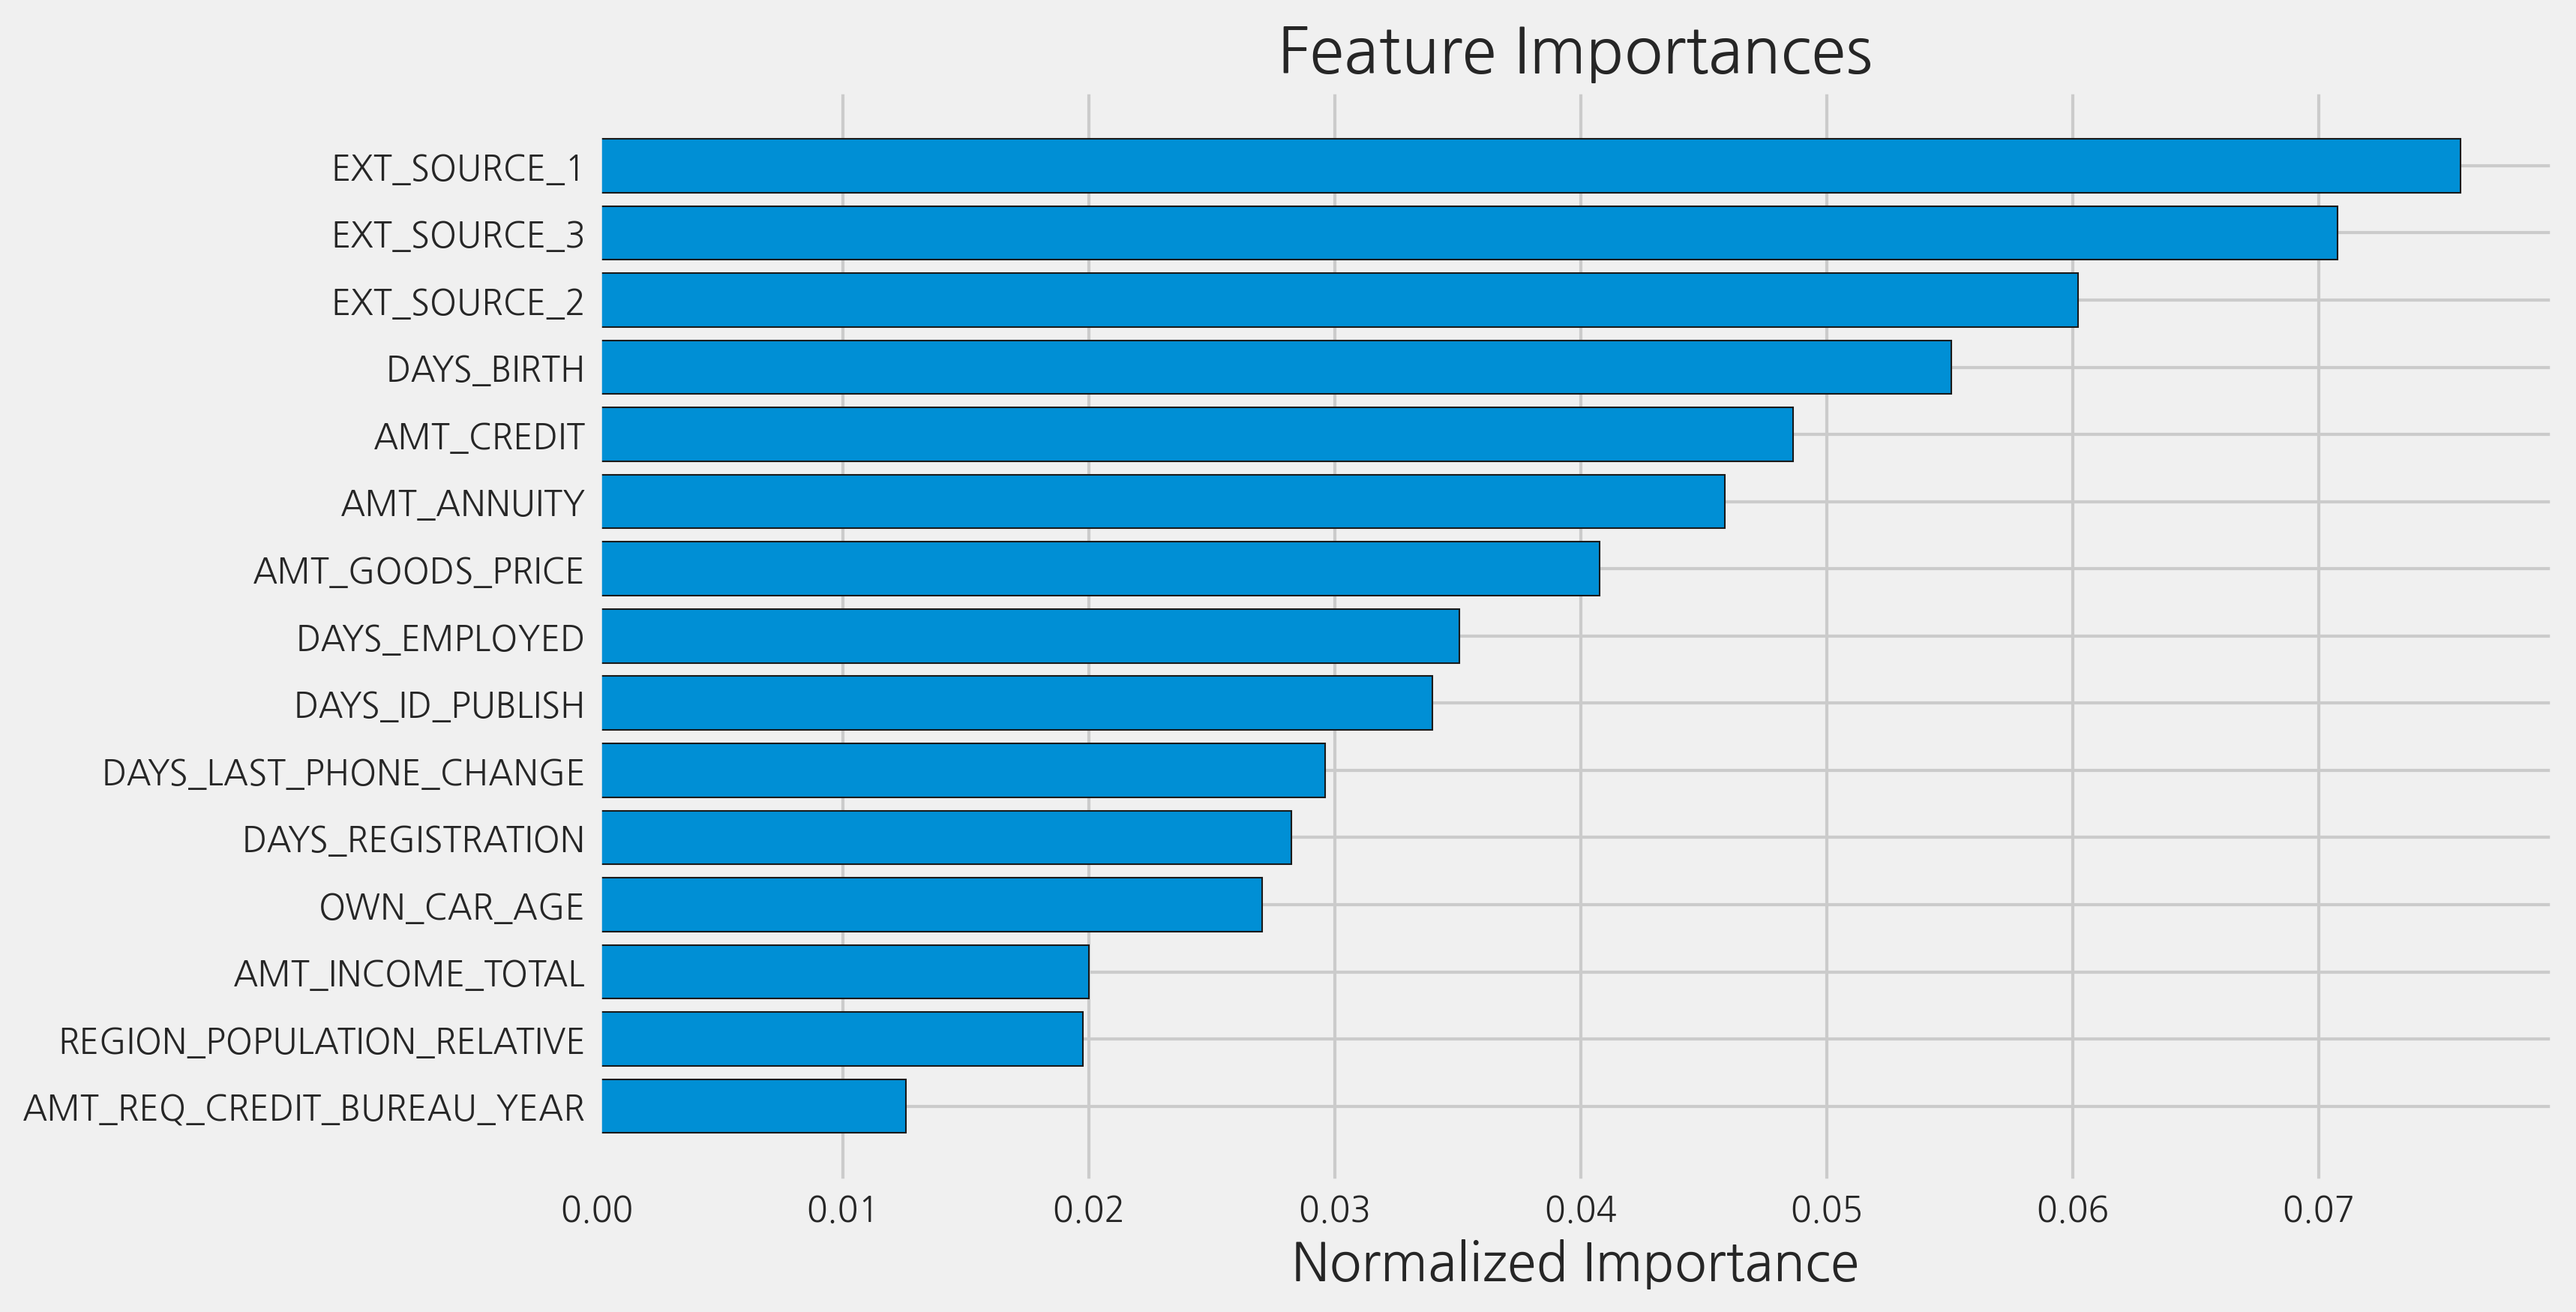

In [71]:
fi_sorted = plot_feature_importances(fi)

In [72]:
submission.to_csv('control.csv', index=False)

**control 점수를 competition에 제출했을 때, 0.745점이 나옵니다**

### Test One
첫번째 테스트를 수행해봅닌다.

In [73]:
submission_raw, fi_raw, metrics_raw = model(train, test)

Training Data Shape:  (307511, 452)
Testing Data Shape:  (48744, 452)
[200]	train's auc: 0.811091	train's binary_logloss: 0.536004	valid's auc: 0.762185	valid's binary_logloss: 0.553428
[200]	train's auc: 0.810484	train's binary_logloss: 0.536712	valid's auc: 0.763737	valid's binary_logloss: 0.554134
[400]	train's auc: 0.843715	train's binary_logloss: 0.502446	valid's auc: 0.763956	valid's binary_logloss: 0.53294
[200]	train's auc: 0.809067	train's binary_logloss: 0.538776	valid's auc: 0.773125	valid's binary_logloss: 0.552747
[200]	train's auc: 0.810148	train's binary_logloss: 0.537041	valid's auc: 0.766342	valid's binary_logloss: 0.552978
[200]	train's auc: 0.810749	train's binary_logloss: 0.536621	valid's auc: 0.763264	valid's binary_logloss: 0.55501
[400]	train's auc: 0.844013	train's binary_logloss: 0.502255	valid's auc: 0.763716	valid's binary_logloss: 0.53378


In [74]:
metrics_raw

,fold,train,valid
0,0,0.822110,0.762439
1,1,0.833192,0.764422
2,2,0.813552,0.773428
3,3,0.824910,0.766902
4,4,0.835967,0.764130
5,overall,0.825946,0.766171


이 숫자를 기반으로 하면 engineered features가 control보다 더 나은 성능을 보입니다. 그러나 더 나은 validation performance가 테스트 데이터로 이전되는지 여부를 말하기 전에 predictions을 리더보드에 제출해야 합니다.

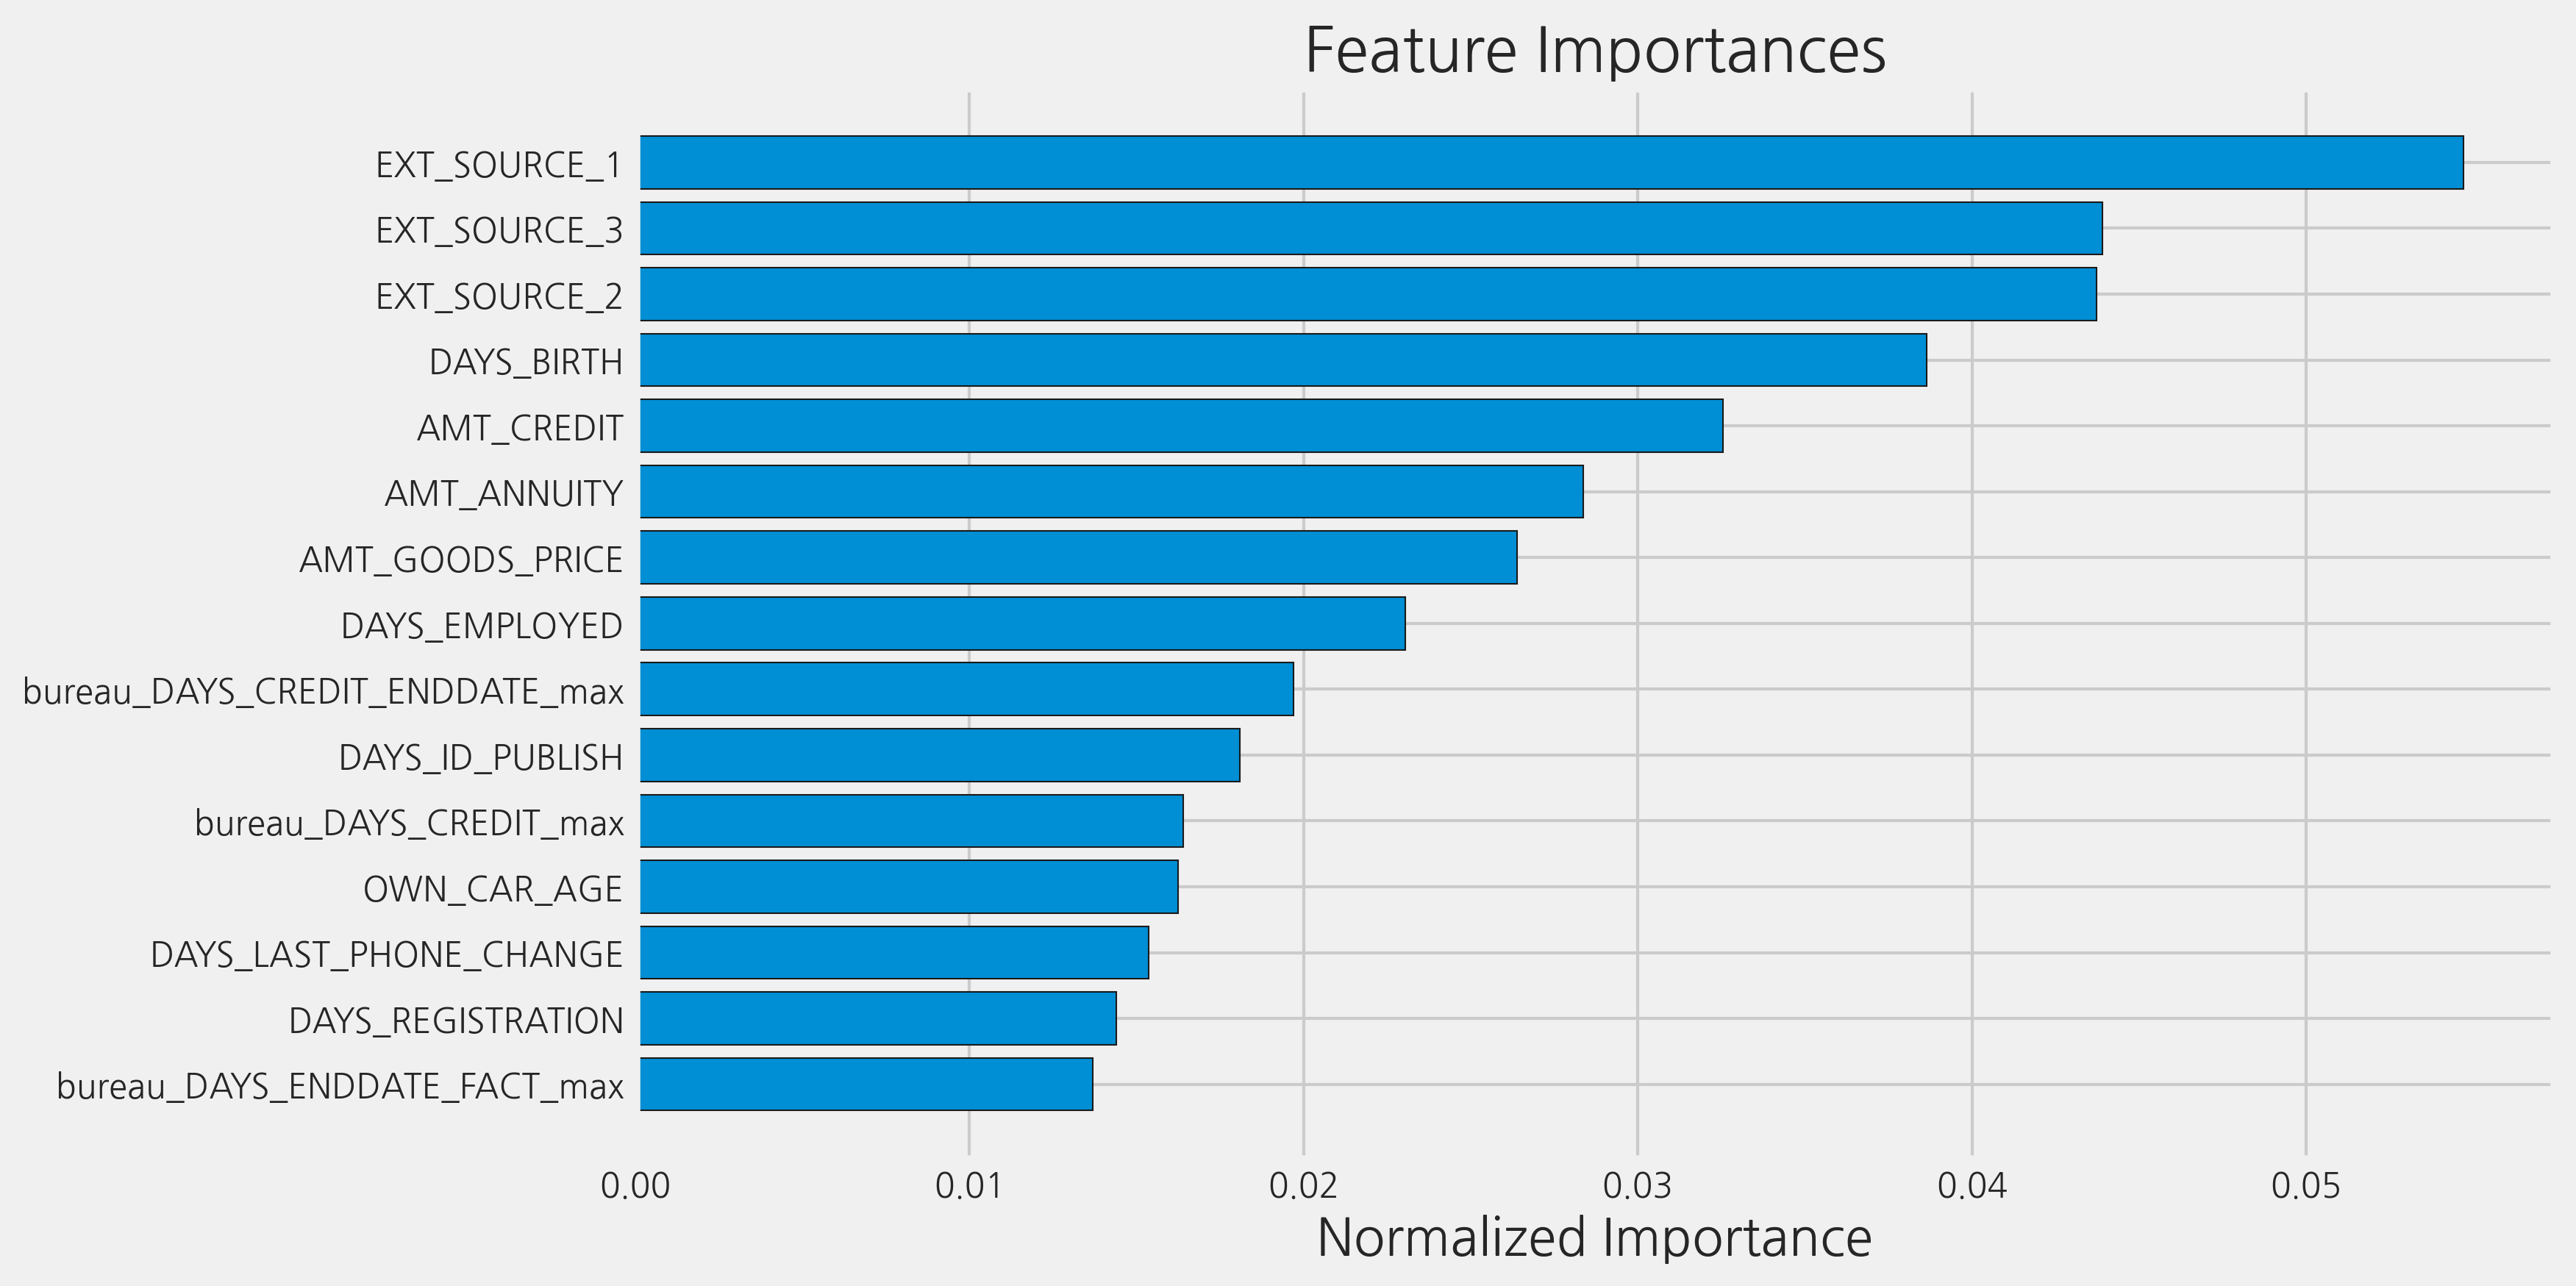

In [75]:
fi_raw_sorted = plot_feature_importances(fi_raw)

feature importances를 검토하면, 여기서 구성한 feature 중 몇 가지가 가장 중요한 것처럼 보입니다. 가장 중요한 상위 100개 중 이 노트북에서 만든 feature의 비율을 알아보겠습니다. 그러나 단순히 original feature과 비교하기 보다는 ohe-hot encoding된 original feature과 비교해야 합니다. 이것들은 이미 ```fi```(from the original data)에 기록되어 있습니다.

In [76]:
top_100 = list(fi_raw_sorted["feature"])[:100]
new_features = [x for x in top_100 if x not in list(fi["feature"])]
print('%% of Top 100 Features created from the bureau data = %d.00' % len(new_features))

% of Top 100 Features created from the bureau data = 51.00


상위 100개 features 중 절반 이상이 직접 만든 것입니다. 이것은 이 노트북에서 한 모든 수고가 가치가 있다는 확신을 줍니다.

In [77]:
submission_raw.to_csv('test_one.csv', index=False)

**Test one의 점수는 competition에 제출했을 때, 0.759가 나옵니다.**

### Test Two
두번째 테스트를 시행해봅니다. 높은 collinear 변수를 제거한 것을 제외하고는 모두 같습니다.

In [78]:
submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

Training Data Shape:  (307511, 318)
Testing Data Shape:  (48744, 318)
[200]	train's auc: 0.807422	train's binary_logloss: 0.539513	valid's auc: 0.759621	valid's binary_logloss: 0.556926
[400]	train's auc: 0.839903	train's binary_logloss: 0.506616	valid's auc: 0.759995	valid's binary_logloss: 0.536408
[200]	train's auc: 0.807015	train's binary_logloss: 0.540062	valid's auc: 0.761293	valid's binary_logloss: 0.557095
[200]	train's auc: 0.805439	train's binary_logloss: 0.542201	valid's auc: 0.768845	valid's binary_logloss: 0.556151
[200]	train's auc: 0.806567	train's binary_logloss: 0.540328	valid's auc: 0.764513	valid's binary_logloss: 0.556112
[200]	train's auc: 0.806983	train's binary_logloss: 0.540159	valid's auc: 0.760385	valid's binary_logloss: 0.558183


In [79]:
metrics_corr

,fold,train,valid
0,0,0.835091,0.760462
1,1,0.823631,0.762023
2,2,0.817454,0.769063
3,3,0.821215,0.765296
4,4,0.816424,0.761042
5,overall,0.822763,0.763526


control보다는 결과가 조금 더 낫지만, raw features보다는 약간 낮습니다.

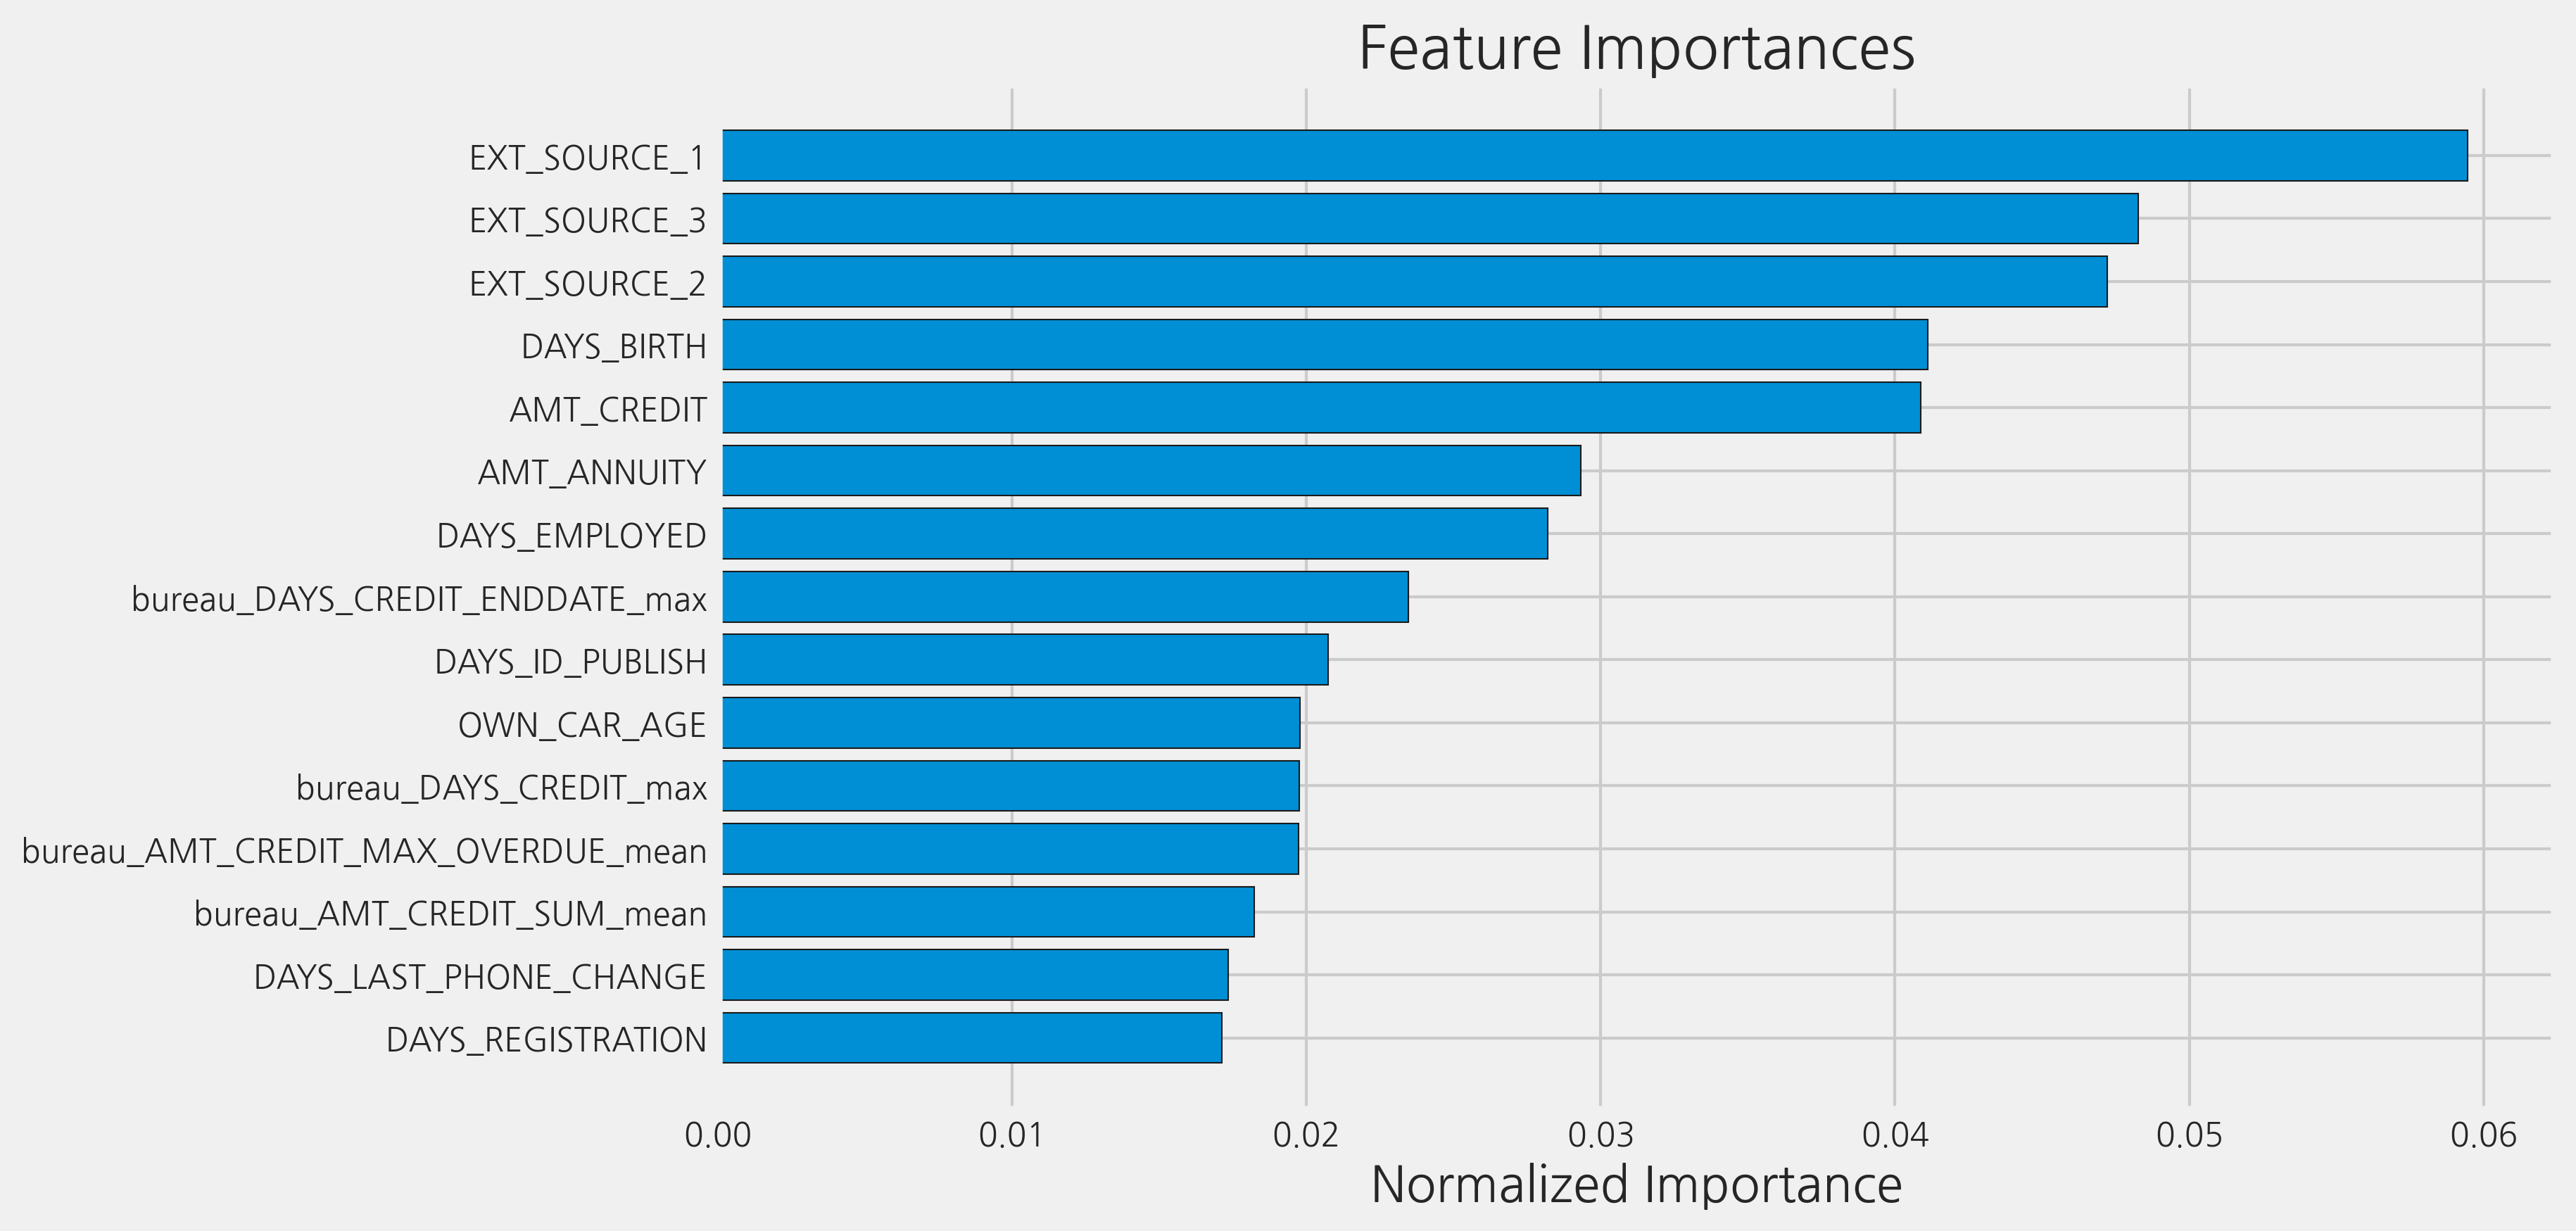

In [80]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [81]:
submission_corrs.to_csv('test_two.csv', index=False)

**Test two는 competition에 제출했을 때, 0.753점이 나옵니다.**

# Results
모든 작업을 마친 후 extra information를 포함하면 성능이 향상되었다고 말할 수 있습니다. 모델은 확실히 데이터에 최적화되어 있지 않지만 calculated features을 사용할 때 원래 데이터 세트보다 눈에 띄게 개선되었습니다.